# Índice
- **0.0. Imports**
- **1.0. Descricao dos Dados**
- **2.0. Feature Engineering**
- **3.0. Exploratory Data Analysis**
- **4.0. Filtragem**
- **5.0. Tratamento**
- **6.0. Selecao de Features**
- **7.0. Modelagem de Machine Learning**
- **8.0. Otimizacao de Hiperparametros**
- **9.0. Avaliacao**
- **10.0. Interpretação do Erro**
- **11.0. Deploy**

# 0.0. Imports

In [59]:
# Manipulacao

from unidecode     import unidecode
from scipy         import stats         as ss
import pandas                           as pd
import numpy                            as np
import random
import pickle
import inflection
import statistics


# Plot
from   IPython.display                  import Image
import seaborn                          as sns
import matplotlib.pyplot                as plt

# Machine Learning
from sklearn.feature_selection          import RFE
from sklearn.model_selection            import train_test_split, KFold
from sklearn.preprocessing              import MinMaxScaler, RobustScaler
from sklearn.ensemble                   import RandomForestRegressor
from sklearn.ensemble                   import RandomForestClassifier
from sklearn.tree                       import DecisionTreeRegressor
from sklearn                            import linear_model as lm
from sklearn.metrics                    import mean_absolute_error, mean_squared_error, r2_score
from boruta import BorutaPy

## 0.1. Funcoes Auxiliares

In [60]:
def jupyter_settings():
    '''
    Faz algumas correcoes no notebook.
    '''
    %matplotlib inline
    
    pd.options.display.float_format = '{:20.3f}'.format
    pd.set_option('display.max_rows', 200)
    
    plt.style.use('bmh')
    plt.rcParams['figure.figsize'] = [25, 12]
    plt.rcParams['font.size'] = 24
    
    sns.set()
    
    
def fillout_reg(df):
    '''
    Funcao para fazer o fillout dos valores NaN usando um modelo de regressao.
    '''
    # lista de colunas com valores NaN
    list_na = df.loc[:, df.isnull().sum() > 0].columns.to_list()
    
    # Transformando as colunas objeto
    columns_cat = df.select_dtypes(include='object').columns.to_list()
    
    # dicionario que sera aliementado com os novos valores
    dict_new_column = {}
    
    # iterando para transformar as colunas categoricas em dummies
    for value in columns_cat:
        if len(df[value].value_counts()) > 1:
            get_dum = pd.get_dummies(df[value])
            df = pd.concat([df, get_dum], axis=1)
        df.drop(value, inplace=True, axis=1)
    
    # iterando para treinar o modelo
    for value in list_na:
        X_train = df[df[value].notnull()].copy()
        y_train = df[df[value].notnull()][value].copy()

        X_preench = df[df[value].isnull()].copy()
        y_preench = df[df[value].isnull()][value].copy()
        
        X_train.drop(list_na, axis=1, inplace=True)
        X_preench.drop(list_na, axis=1, inplace=True)
        
        # modelo de DecisionTreeRegressor
        model = DecisionTreeRegressor(random_state=32)
        model.fit(X_train, y_train)
        
        y_preench = model.predict(X_preench)
        dict_new_column[value] = y_preench
        
    return dict_new_column # Retornando o dicionario a ser aplicado


def mean_percentage_error(y, yhat):
    '''
    calculo do MAE
    '''
    return np.mean((y - yhat ) / y)
    
    
def mean_absolute_percentage_error(y, yhat):
    '''
    calculo do MAPE
    '''
    return np.mean(np.abs((y - yhat) / y))


def ml_performance(X=None, y=None, modelo=None, baseline=False, mape_eval=False, folds=10, tree=None, scaler=None):
    '''
    Avalia a performance do modelo com CrossValidation
    '''
    
    # Numero de folds do CrossValidation
    kf = KFold(n_splits=folds)
    
    list_mae = [] # Lista a ser alimentada com os valores de MAE de cada iteracao
    list_mape = [] # Lista a ser alimentada com os valores de MAPE de cada iteracao
    list_r2 = [] # Lista a ser alimentada com os valores de R2 de cada iteracao
    
    # Iterando por cada Fold
    for train_index, test_index in kf.split(X, y):
        
        # Separando os dados de Treino
        X_train = X.iloc[train_index, :].reset_index(drop=True)
        y_train = y.iloc[train_index].reset_index(drop=True)
        
        # Separando os dados para Calidacao
        X_valid = X.iloc[test_index, :].reset_index(drop=True)
        y_valid = y.iloc[test_index].reset_index(drop=True)
        
        # Condicional para caso o modelo seja o Baseline
        if baseline == False:
            
            # Condicional para caso o modelo nao seja de arvore, para que possa passar pelo Scaler
            if tree == False:
                
                # Scaler utilizado
                scaler = scaler
                
                # Substituindo os valores das colunas pelos valores em nova escala
                for value in X_train.columns:
                    scaled_train = scaler.fit_transform(X_train[[value]].values)
                    X_train[value] = scaled_train.copy()

                    scaled_test = scaler.fit_transform(X_valid[[value]].values)
                    X_valid[value] = scaled_test
            
            # Treino do modelo
            model = modelo.fit(X_train, y_train)

            # Predicoes
            yhat = model.predict(X_valid)
            
        # Caso o Modelo Seja Baseline    
        else:
            
            # Calculo da baseline usando a media dos dados de treino
            y_baseline = np.mean(y_train)
            X_valid['baseline'] = y_baseline
            yhat = X_valid.loc[:, 'baseline']
            X_valid = X_valid.drop('baseline', axis=1)
        
        # Calculando o MAE e salvando na sua lista
        mae = mean_absolute_error(np.expm1(y_valid), np.expm1(yhat))
        list_mae.append(mae)
        
        # Calculando o MAPE e salvando na sua lista
        mape = mean_absolute_percentage_error(np.expm1(y_valid), np.expm1(yhat))
        list_mape.append(mape)
        
        # Calculando o R2 e salvando na sua lista
        r2 = r2_score(np.expm1(y_valid), np.expm1(yhat))
        list_r2.append(r2)
    
    # Caso o modelo nao seja de baseline - Usar desvio padroes
    if baseline == False:
        
        mae_value = f'{round(np.mean(list_mae), 3)} +/- {round(np.std(list_mae), 3)}'
        mape_value = f'{round(np.mean(list_mape), 3)} +/- {round(np.std(list_mape), 3)}'
        r2_value = f'{round(np.mean(list_r2), 3)} +/- {round(np.std(list_r2), 3)}'
        name = type(modelo).__name__

    
    # Caso o modelo seja de baseline - Adicionar apenas a media das listas
    else:
        r2_value = np.mean(list_r2)
        mape_value = np.mean(list_mape)
        mae_value = np.mean(list_mae)
        name = 'AverageModel'
        
    # Caso os valores nao sejam de avaliacao na otimizacao de hiperparametros - Retorne o DataFrame
    if mape_eval == False:
        return pd.DataFrame({'Model Name': name, 
                             'MAE': mae_value, 
                             'MAPE': mape_value,
                             'R2': r2_value}, index=[0])
    
    # Caso os valores sejam de avaliacao na otimizacao de hiperparametros - o valor MAPE
    else:
        return np.mean(list_mape)

In [61]:
# Ativando as configuracoes
jupyter_settings()

## 0.2. Import Data

In [62]:
# Abertura do arquivo de dados principal
df_fat = pd.read_csv('/home/tcbm/projs/case_geofusion/data/DesafioEstagioMachineLearning.csv')
df_fat['nome'] = df_fat['nome'].apply(lambda x: unidecode(x)).copy()

In [63]:
# Abertura do arquivo raspado da web:
# subprefeituras e reg adm
df_sub = pd.read_csv('/home/tcbm/projs/case_geofusion/data/sub_adm_data.csv')

# idh e area
df_num = pd.read_csv('/home/tcbm/projs/case_geofusion/data/area_idh_data.csv')

In [64]:
# merge para o dataframe final
df_to_merge = pd.merge(df_sub, df_num, how='outer', on='nome')
df = pd.merge(df_fat, df_to_merge, how='inner', on = 'nome')

# 1.0. Descricao dos Dados

In [65]:
# Copiando o dataframe atualizado para a sessão 1
df1 = df.copy()

## 1.1. Mudancas

### 1.1.1. Nome das Colunas

In [66]:
# Selecionando os nomes das colunas antigas como uma lista
old_columns = df1.columns.to_list()

# Alterando o nome das colunas para underscore e tirando ascentos
new_columns = list(map(lambda x: unidecode(inflection.underscore(x)), old_columns))

# Inserindo o novo nome no DataFrame
df1.columns = new_columns

### 1.1.2. Caracteres

In [67]:
# listando as variaveis com valores object
list_variables = df1.dtypes[df1.dtypes == object].index.values

for value in list_variables:
    df1[value] = df1[value].apply(lambda x: unidecode(x))

## 1.2. Dimensao dos Dados

In [68]:
print(f'Numero de linhas: {df1.shape[0]}')
print(f'Numero de colunas: {df1.shape[1]}')

Numero de linhas: 160
Numero de colunas: 27


## 1.3. Tipo dos Dados

In [69]:
df1.dtypes

codigo             int64
nome              object
cidade            object
estado            object
populacao          int64
pop_ate9           int64
pop_de10a14        int64
pop_de15a19        int64
pop_de20a24        int64
pop_de25a34        int64
pop_de35a49        int64
pop_de50a59        int64
pop_mais_de60      int64
domicilios_a1      int64
domicilios_a2      int64
domicilios_b1      int64
domicilios_b2      int64
domicilios_c1      int64
domicilios_c2      int64
domicilios_d       int64
domicilios_e       int64
renda_media      float64
faturamento      float64
subprefeitura     object
regiao_adm        object
area             float64
idh              float64
dtype: object

Todos os dtypes estao sendo usados devidamente. Nao sera preciso fazer alteracoes.

## 1.4. Check de Valores NaN

In [70]:
df1.isnull().sum()

codigo           0
nome             0
cidade           0
estado           0
populacao        0
pop_ate9         0
pop_de10a14      0
pop_de15a19      0
pop_de20a24      0
pop_de25a34      0
pop_de35a49      0
pop_de50a59      0
pop_mais_de60    0
domicilios_a1    0
domicilios_a2    0
domicilios_b1    0
domicilios_b2    0
domicilios_c1    0
domicilios_c2    0
domicilios_d     0
domicilios_e     0
renda_media      6
faturamento      0
subprefeitura    0
regiao_adm       0
area             2
idh              3
dtype: int64

**Valores NaN**:
- renda_media
- area 
- idh

## 1.5. Estatistica Descritiva

In [71]:
# Separando as variaveis numericas e as variaveis categoricas em dois dataframes diferentes
# variaveis numericos
num_attributes = df1.select_dtypes(exclude='object')

# variaveis categoricas
cat_attributes = df1.select_dtypes(include='object')

### 1.5.1. Atributos Numericos

In [72]:
# Central Tendency - mean, meadina 
ct_1 = pd.DataFrame(num_attributes.apply(lambda x: x.mean())).T
ct_2 = pd.DataFrame(num_attributes.apply(lambda x: x.median())).T

# Dispersion - std, min, max, range, skew, kurtosis
d1 = pd.DataFrame(num_attributes.apply(np.std)).T 
d2 = pd.DataFrame(num_attributes.apply(min)).T 
d3 = pd.DataFrame(num_attributes.apply(max)).T 
d4 = pd.DataFrame(num_attributes.apply(lambda x: x.max() - x.min())).T 
d5 = pd.DataFrame(num_attributes.apply(lambda x: x.skew())).T 
d6 = pd.DataFrame(num_attributes.apply(lambda x: x.kurtosis())).T 

# Concat
m = pd.concat([d2, d3, d4, ct_1, ct_2, d1, d5, d6]).T.reset_index()
m.columns = ['attributes', 'min', 'max', 'range', 'mean', 'median', 'std', 'skew', 'kurtosis']
m

attributes                  min                  max  \
0          codigo       3304557001.000       3304557160.000   
1       populacao              173.000           667603.000   
2        pop_ate9               33.000           122578.000   
3     pop_de10a14               13.000            55935.000   
4     pop_de15a19               22.000            62342.000   
5     pop_de20a24               17.000            60567.000   
6     pop_de25a34               28.000            86116.000   
7     pop_de35a49               38.000           105316.000   
8     pop_de50a59               10.000            83341.000   
9   pop_mais_de60               12.000            91408.000   
10  domicilios_a1                0.000            13408.000   
11  domicilios_a2                0.000            11668.000   
12  domicilios_b1                0.000            19350.000   
13  domicilios_b2                0.000            21237.000   
14  domicilios_c1                5.000            33111.000   
15  domicilios_c2                3.000            25779.000   
16   domicilios_d                0.000             4956.000   
17   domicilios_e                2.000            14833.000   
18    renda_media              654.000            63887.000   
19    faturamento            24651.000          2915612.000   
20           area               16.110            13950.120   
21            idh                0.711                0.977   

                  range                 mean               median  \
0               159.000       3304557080.500       3304557080.500   
1            667430.000            42654.350            26076.000   
2            122545.000             5329.062             3111.500   
3             55922.000             2484.444             1434.000   
4             62320.000             3272.156             2015.000   
5             60550.000             3349.381             2142.500   
6             86088.000             6584.475             4170.500   
7            105278.000             8826.862             5657.000   
8             83331.000             5332.262             3371.500   
9             91396.000             7475.706             4575.500   
10            13408.000              388.475                0.000   
11            11668.000              608.269              107.500   
12            19350.000             1871.562              848.000   
13            21237.000             2385.075             1536.000   
14            33106.000             3539.850             2394.500   
15            25776.000             3030.806             1861.500   
16             4956.000              568.375              327.500   
17            14831.000             1821.612             1042.500   
18            63233.000             3608.071             1915.500   
19          2890961.000           876159.969           824228.500   
20            13934.010              781.057              259.900   
21                0.266                0.843                0.840   

                    std                 skew             kurtosis  
0                46.187                0.000               -1.200  
1             64061.813                6.430               56.988  
2             10782.346                8.455               87.995  
3              4933.338                8.385               86.770  
4              5734.153                7.402               71.039  
5              5584.360                7.254               69.288  
6              9021.571                5.159               38.472  
7             11500.169                4.691               32.096  
8              7961.266                6.496               57.989  
9             10226.200                4.725               30.970  
10             1399.212                6.220               49.005  
11             1530.433                4.739               26.227  
12             2964.224                3.699               16.430  
13             27

### 1.5.2. Atributos Categoricos

In [73]:
# Determinando a moda de cada coluna categorica
moda = pd.DataFrame(cat_attributes.apply(lambda x: statistics.mode(x)))
moda.columns = ['moda']
moda

moda
nome                 Abolicao
cidade         Rio de Janeiro
estado                     RJ
subprefeitura      Zona Norte
regiao_adm              Meier

## 1.6. Outliers - Erros

Durante a análise descritiva, duas variáveis chamaram atenção pelo valor máximo:
- renda_media
- população

### 1.6.1. renda_media

<AxesSubplot:xlabel='renda_media'>

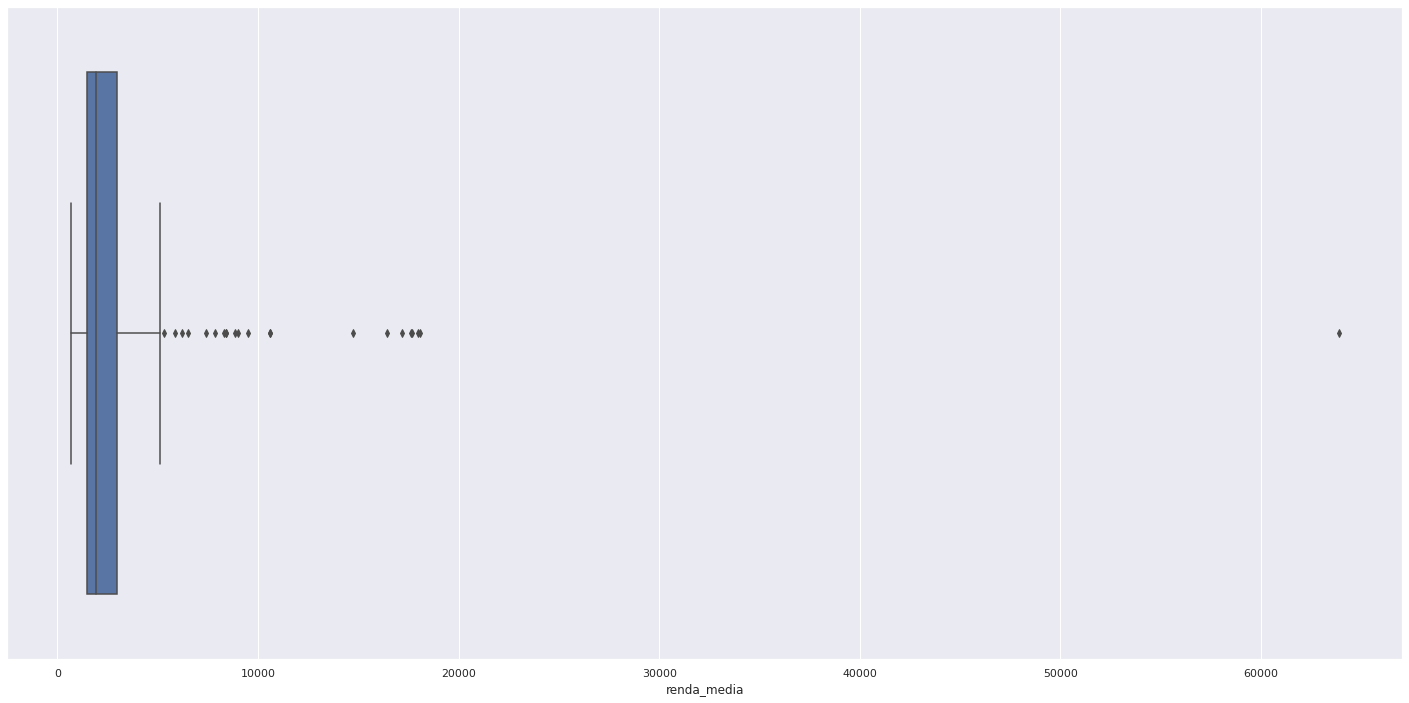

In [74]:
# plot boxplot renda_media
sns.boxplot(x = df1['renda_media'])

In [75]:
# levantando o valor que possui essa renda media, com o seu nome
df1.loc[df1['renda_media'] > 60000, ['nome', 'renda_media']]

nome          renda_media
80  Lagoa            63887.000

A renda_media de 63887.00 é, provavelmente, algum tipo de erro. Esse valor será subsitituido por um valor NULL para que possa ser aproximado através do fillout de NA.

In [76]:
# substituindo o valor da renda media para um valor NULL. Dessa forma, o valor será substituido na proxima etapa
df1.loc[df1['nome'] == 'Lagoa', 'renda_media'] = np.nan

### 1.6.2. populacao

<AxesSubplot:xlabel='populacao'>

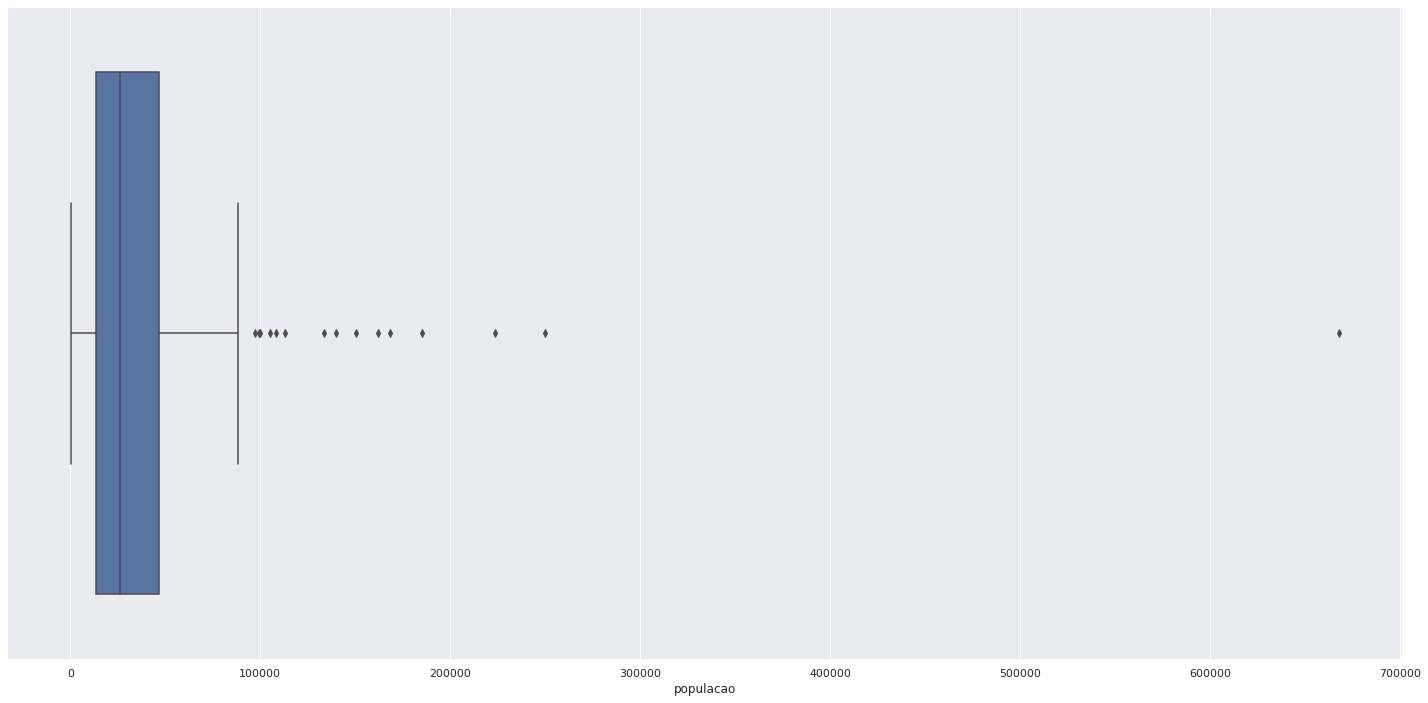

In [77]:
# plot boxplot populacao
sns.boxplot(x = df1['populacao'])

In [78]:
# Encontrando o valor
df1.loc[df1['populacao'] > 600000, ['nome', 'populacao']]

nome  populacao
23  Campo Grande     667603

Campo Grande é um bairro com alta populacao. No entanto, esse valor esta muito acima do real. Sera substituito por NULL e previsto na proxima sessao.

In [79]:
# Transformando essa entrada em NaN para a proxima etapa
df1.loc[df1['nome'] == 'Campo Grande', 'populacao'] = np.nan

## 1.7. Substituicao - NaN

### 1.7.1. Substituicao

In [80]:
# Chamando a funcao de fillout com regressao linear
a = fillout_reg(df1)

In [81]:
# Substituindo valores NaN de renda media pelos valores previstos
df1.loc[df1['renda_media'].isnull(), 'renda_media'] = a['renda_media']

# Substituindo valores NaN de area pelos valores previstos
df1.loc[df1['area'].isnull(), 'area'] = a['area']

# Substituindo valores NaN de idh pelos valores previstos
df1.loc[df1['idh'].isnull(), 'idh'] = a['idh']

# Substituindo valores NaN de populacao pelos valores previstos
df1.loc[df1['populacao'].isnull(), 'populacao'] = a['populacao']

In [82]:
# Conferindo os valores NaN
df1.isnull().sum()

codigo           0
nome             0
cidade           0
estado           0
populacao        0
pop_ate9         0
pop_de10a14      0
pop_de15a19      0
pop_de20a24      0
pop_de25a34      0
pop_de35a49      0
pop_de50a59      0
pop_mais_de60    0
domicilios_a1    0
domicilios_a2    0
domicilios_b1    0
domicilios_b2    0
domicilios_c1    0
domicilios_c2    0
domicilios_d     0
domicilios_e     0
renda_media      0
faturamento      0
subprefeitura    0
regiao_adm       0
area             0
idh              0
dtype: int64

### 1.7.1. Novos Valores -  Outliers

In [83]:
# Conferindo os novos valores para as variaveis com outliers
df1.loc[df1['nome'] == 'Lagoa', 'renda_media']

80              17650.000
Name: renda_media, dtype: float64

In [84]:
# Conferindo os novos valores para as variaveis com outliers
df1.loc[df1['nome'] == 'Campo Grande', 'populacao']

23             249987.000
Name: populacao, dtype: float64

Agora os valores estao muito mais proximos da realidade e nao irao mais prejudicar a analise.

Obs: Após outra analise, percebe-se que a entrada Campo Grande é problemática. Possui alguns valores irreais e difíceis de serem corrigidos agora. Esse bairro será excluido na parte de filtragem.

In [85]:
#df1.to_csv('/home/tcbm/projs/case_geofusion/data/df_to_analysis_2.csv', encoding='utf-8', index=False)

# 2.0. Feature Engineering

In [86]:
# copiando o dataframe para df2
df2 = df1.copy()

## 2.1. Mapa Mental de Hipoteses

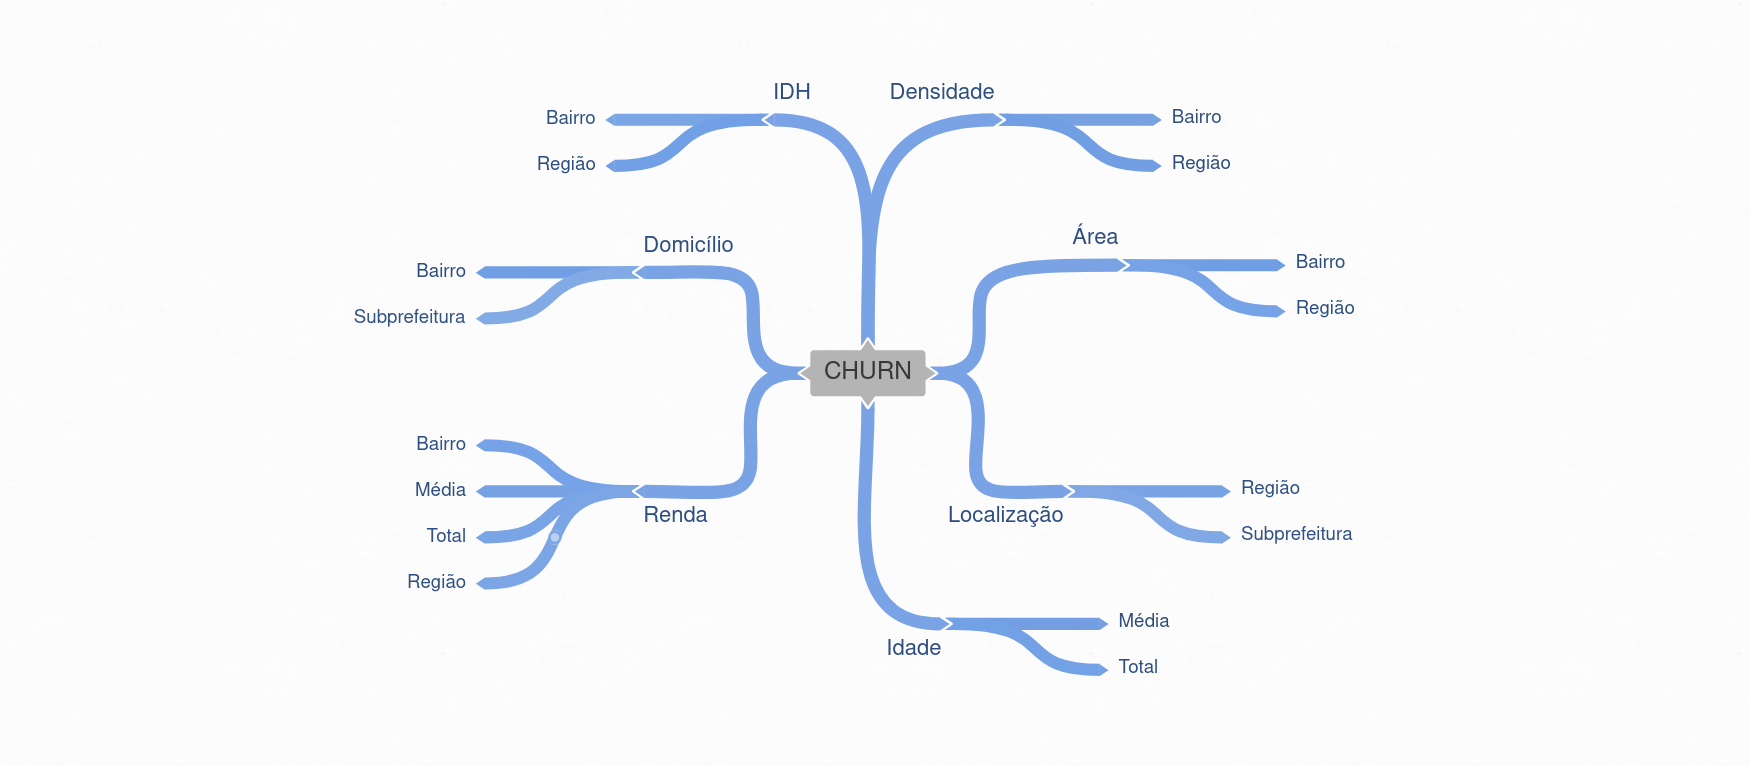

## 2.2. Hipoteses

**H1.** IDH Bairro x Faturamento

**H2.** IDH Subprefeitura x Faturamento

**H3.** Densidade Bairro x Faturamento

**H4.** Densidade Subprefeitura x Faturamento

**H5.** Renda Total Bairro x Faturamento

**H6.** Renda Média Bairro x Faturamento

**H7.** Renda total Subprefeitura x Faturamento

**H8.** Renda Média Subprefeitura x Faturamento

**H9.** Bairro x Faturamento - Top 10 Faturamentos - Bairros

**H10.** Região Adm x Faturamento - Top 10 Faturamentos - Região Administrativa

**H11.** Subprefeitura x Faturamento Top 10 Faturamentos - Subprefeitura

**H12.** Idade Total Bairro x Faturamento

**H13.** Domicílio Bairro x Faturamento

**H14.** População Absoluta Bairro x Faturamento

**H15.** População Absoluta Subprefeitura x Faturamento

## 2.3. Feature Engineering

### 2.3.1. IDH medio por subprefeitura

In [87]:
# Calculo do IDH medio por subprefeitura
aux_1 = df2[['idh', 'subprefeitura']].groupby('subprefeitura').mean().reset_index()
aux_1.columns = ['subprefeitura', 'idh_subprefeitura']
df2 = df2.merge(aux_1, how='inner', on='subprefeitura')

### 2.3.2. Populacao Subprefeitura

In [88]:
# Calculo da populacao por subprefeitura
aux_2 = df2[['populacao', 'subprefeitura']].groupby('subprefeitura').sum().reset_index()
aux_2.columns = ['subprefeitura', 'populacao_subprefeitura']
df2 = df2.merge(aux_2, how='inner', on='subprefeitura')

### 2.3.3. Densidade Subprefeitura -> densidade = pop / area

In [89]:
# Calculo da densidade subprefeitura -> densidade = pop / area 
aux_3 = df2[['area', 'subprefeitura']].groupby('subprefeitura').sum().reset_index()
aux_3.columns = ['subprefeitura', 'area_subprefeitura']
df2 = df2.merge(aux_3, how='inner', on='subprefeitura')

df2['densidade_subprefeitura'] = df2['populacao_subprefeitura'] / df2['area_subprefeitura']

### 2.3.4. Densidade Bairro

In [90]:
# Calculo da densidade bairro -> densidade = pop / area 
df2['densidade_bairro'] = df2['populacao'] / df2['area']

### 2.3.5. Total Domicílios por Bairro

In [91]:
# total domicilios por bairro
df2['total_domicilios'] = (df2['domicilios_a1'] + df2['domicilios_a2'] +
                           df2['domicilios_b1'] + df2['domicilios_b2'] +
                           df2['domicilios_c1'] + df2['domicilios_c2'] +
                           df2['domicilios_d'] + df2['domicilios_e'])

### 2.3.6. Renda total Bairro

In [92]:
# Coluna com a renda absoluta do bairro
df2['renda_abs_bairro'] = df2['renda_media'] * df2['total_domicilios']

### 2.3.7 .Renda media Subprefeitura

In [93]:
# Criando dataframe auxiliar com os valores de domicilios totais por subprefeitura
aux_1 = df2[['total_domicilios', 'subprefeitura']].groupby('subprefeitura').sum().reset_index()
aux_1.columns = ['subprefeitura', 'total_domicilios_sub']
aux_2 = pd.merge(df2, aux_1, on='subprefeitura')

# Criando aux_4 com os valores medios por subprefeitura
aux_3 = aux_2.loc[:, ['nome', 'subprefeitura', 'renda_media', 'total_domicilios', 'total_domicilios_sub']]
aux_3['pond'] = aux_3['renda_media'] * aux_3['total_domicilios'] / aux_3['total_domicilios_sub']
aux_4 = aux_3[['pond', 'subprefeitura']].groupby('subprefeitura').sum().reset_index()
aux_4.columns = ['subprefeitura', 'renda_media_subprefeitura']

# Adicionando a coluna no dataframe
df2 = df2.merge(aux_4, how='inner', on='subprefeitura')

### 2.3.7. Domicílios percentuais por bairro

In [94]:
# Substituindo valores brutos do numero de domicilios por valores percentuais
df2['percent_domicilios_a1'] = df2['domicilios_a1'] / df2['total_domicilios']
df2['percent_domicilios_a2'] = df2['domicilios_a2'] / df2['total_domicilios']
df2['percent_domicilios_b1'] = df2['domicilios_b1'] / df2['total_domicilios']
df2['percent_domicilios_b2'] = df2['domicilios_b2'] / df2['total_domicilios']
df2['percent_domicilios_c1'] = df2['domicilios_c1'] / df2['total_domicilios']
df2['percent_domicilios_c2'] = df2['domicilios_c2'] / df2['total_domicilios']
df2['percent_domicilios_d'] = df2['domicilios_d'] / df2['total_domicilios']
df2['percent_domicilios_e'] = df2['domicilios_e'] / df2['total_domicilios']

# Apagando as colunas de valores brutos
df2 = df2.drop(['domicilios_a1', 'domicilios_a2', 'domicilios_b1', 
                'domicilios_b2', 'domicilios_c1', 'domicilios_c2',
                'domicilios_d', 'domicilios_e'], axis=1)

###  2.3.8. percent_idade_bairro

In [95]:
# Substituindo valores brutos da populacao por idade por valores percentuais
df2['percent_pop_ate9'] = df2['pop_ate9'] / df2['populacao']
df2['percent_pop_de10a14'] = df2['pop_de10a14'] / df2['populacao']
df2['percent_pop_de15a19'] = df2['pop_de15a19'] / df2['populacao']
df2['percent_pop_de20a24'] = df2['pop_de20a24'] / df2['populacao']
df2['percent_pop_de25a34'] = df2['pop_de25a34'] / df2['populacao']
df2['percent_pop_de35a49'] = df2['pop_de35a49'] / df2['populacao']
df2['percent_pop_de50a59'] = df2['pop_de50a59'] / df2['populacao']
df2['percent_pop_mais_de60'] = df2['pop_mais_de60'] / df2['populacao']

# Apagando as colunas de valores brutos
df2 = df2.drop(['pop_ate9', 'pop_de10a14', 'pop_de15a19', 'pop_de20a24',
                'pop_de25a34', 'pop_de35a49', 'pop_de50a59', 'pop_mais_de60'], axis=1)

### 2.3.9. Separando Domicilios

In [96]:
# domicilio A e B
df2['percent_ab'] = (df2['percent_domicilios_a1'] + df2['percent_domicilios_a2'] + 
                     df2['percent_domicilios_b1'] + df2['percent_domicilios_b2'])

# domicilios C, D e E
df2['percent_cde'] = (df2['percent_domicilios_c1'] + df2['percent_domicilios_c2'] + 
                      df2['percent_domicilios_d'] + df2['percent_domicilios_e'])

### 2.3.10. Separando Idades

In [97]:
# idade 50+
df2['percent_50+'] = df2['percent_pop_de50a59'] + df2['percent_pop_mais_de60']

# idade 50-
df2['percent_50-'] = (df2['percent_pop_ate9'] + df2['percent_pop_de10a14'] +
                      df2['percent_pop_de15a19'] + df2['percent_pop_de20a24'] +
                      df2['percent_pop_de25a34'] + df2['percent_pop_de35a49'])

In [98]:
df2.loc[df2['nome'] == 'Pechincha', 'total_domicilios']

83    13226
Name: total_domicilios, dtype: int64

In [99]:
df1.loc[df1['nome'] == 'Pechincha', 'renda_media']

104               3089.000
Name: renda_media, dtype: float64

# 3.0. Exploratory Data Analysis

In [100]:
# copiando o dataframe para df2
df3 = df2.copy()
#df3.to_csv('/home/tcbm/projs/case_geofusion/data/df_to_analysis.csv', encoding='utf-8', index=False)

## 3.1. Analise Univariada

### 3.1.1. Variavel Resposta

<AxesSubplot:xlabel='faturamento', ylabel='Count'>

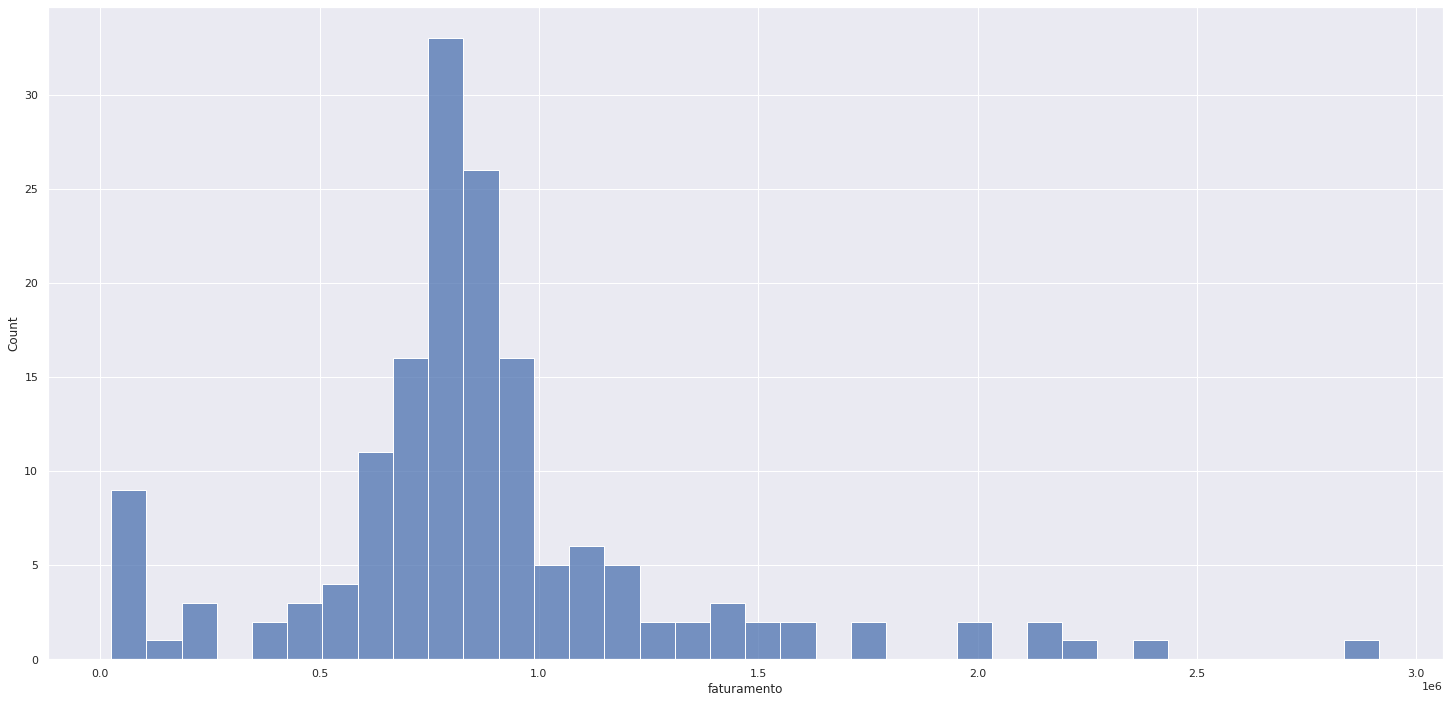

In [101]:
# Plotando o histograma da variavel resposta
sns.histplot(df2['faturamento'])

### 3.1.2. Variaveis Numericas

In [102]:
# Selecionando apenas as variaveis numericas
num_attributes = df3.select_dtypes(exclude='object')

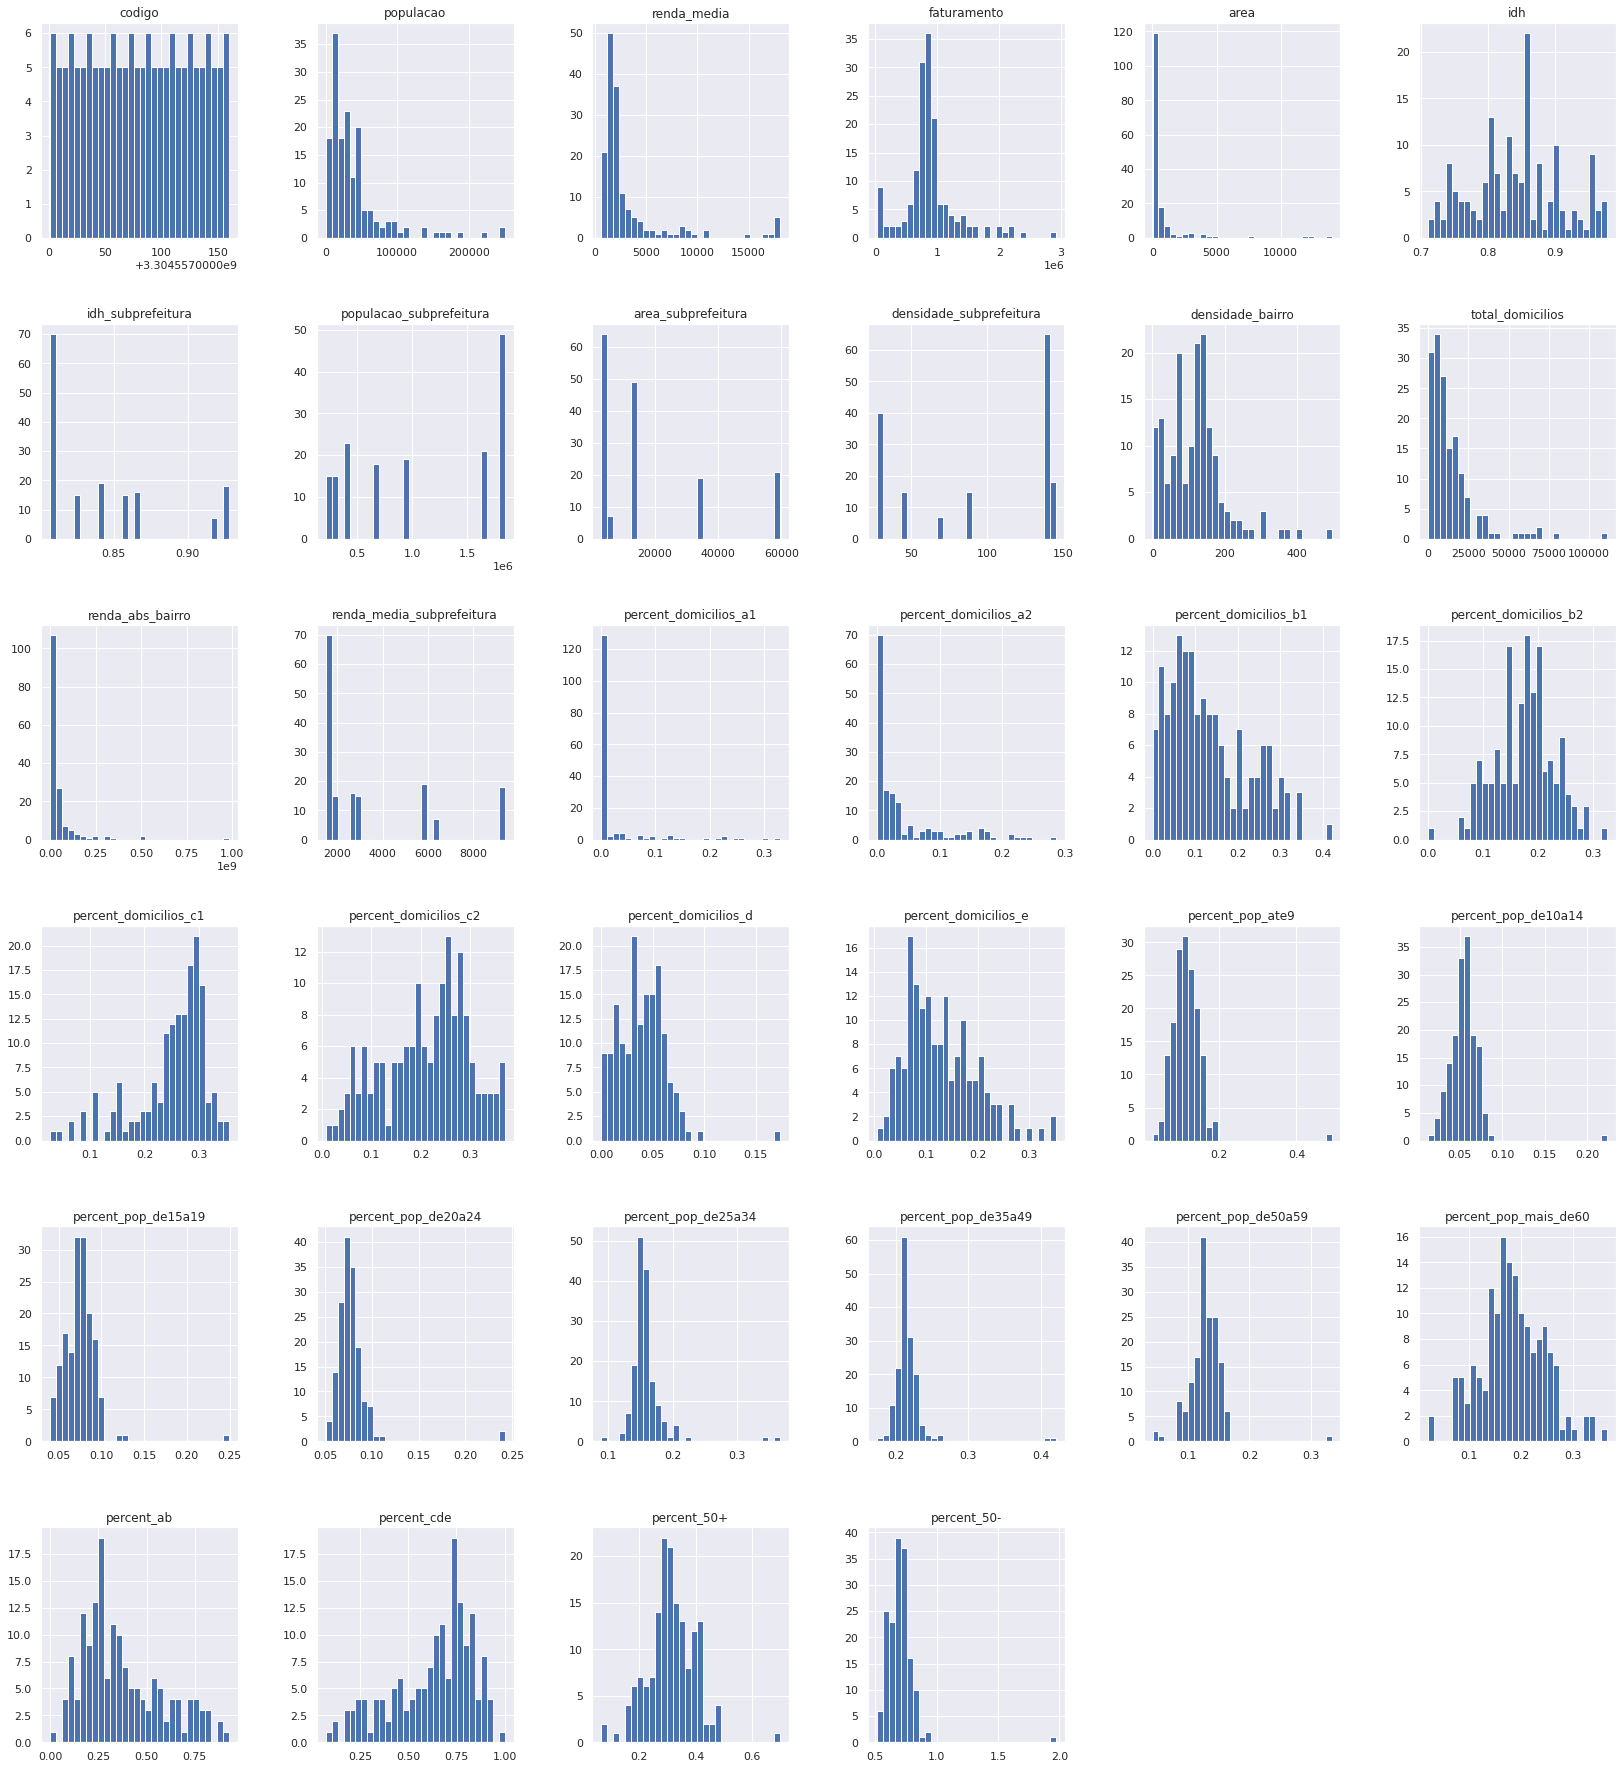

In [103]:
# Plotando os histogramas de todas as variaveis numericas
num_attributes.hist(bins=30);

# Ajustando as imagens
plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=1, 
                    top=2, 
                    wspace=0.4, 
                    hspace=0.40)

### 3.1.3. Variaveis Categoricas

In [104]:
# Separando as variaveis categoricas
cat_attributes = df3.select_dtypes(include='object')

<AxesSubplot:xlabel='subprefeitura', ylabel='faturamento'>

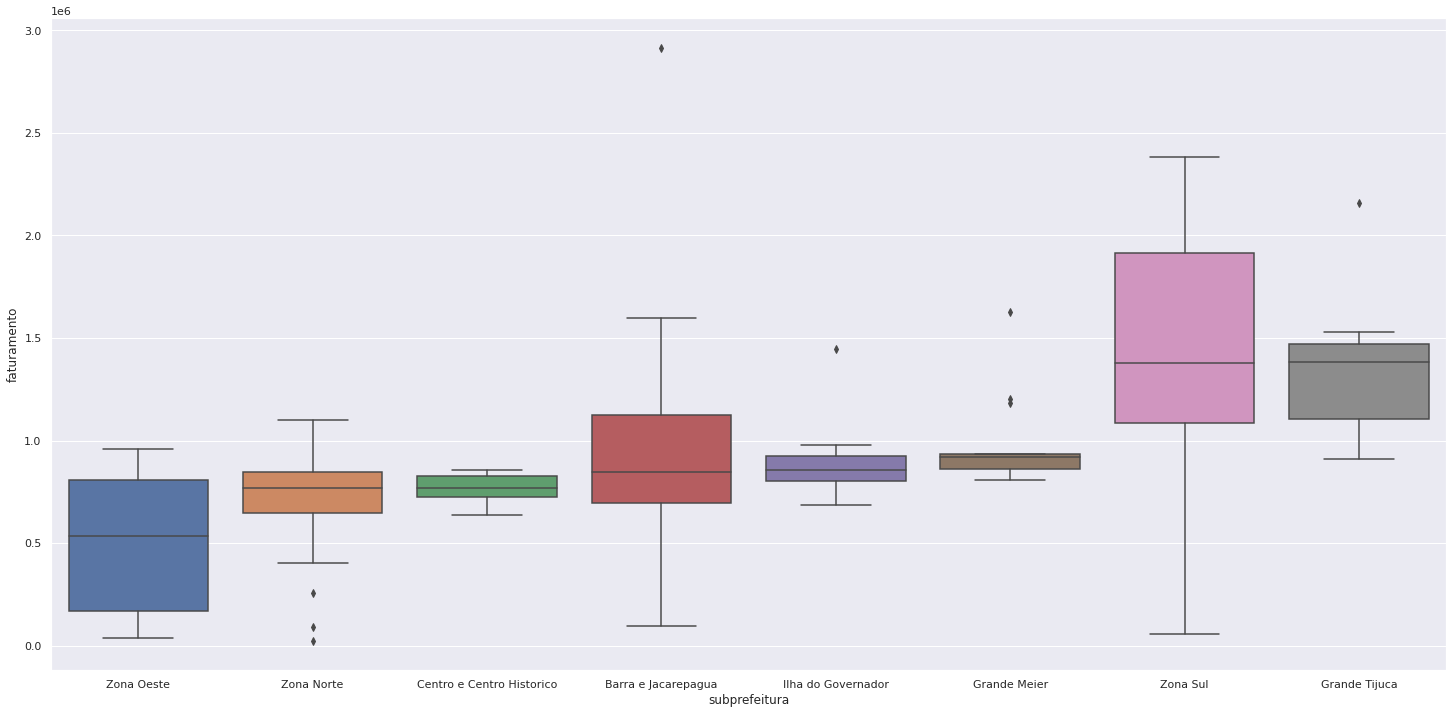

In [105]:
# Criando um df auxiliar para agrupar os valores pela mediana
aux = df1[['subprefeitura', 'faturamento']].groupby('subprefeitura').median().reset_index().sort_values(by = 'faturamento',
                                                                                                        ascending=True)
# plot boxplot
sns.boxplot(x='subprefeitura', y='faturamento', data=df1, order = aux['subprefeitura'].to_list())

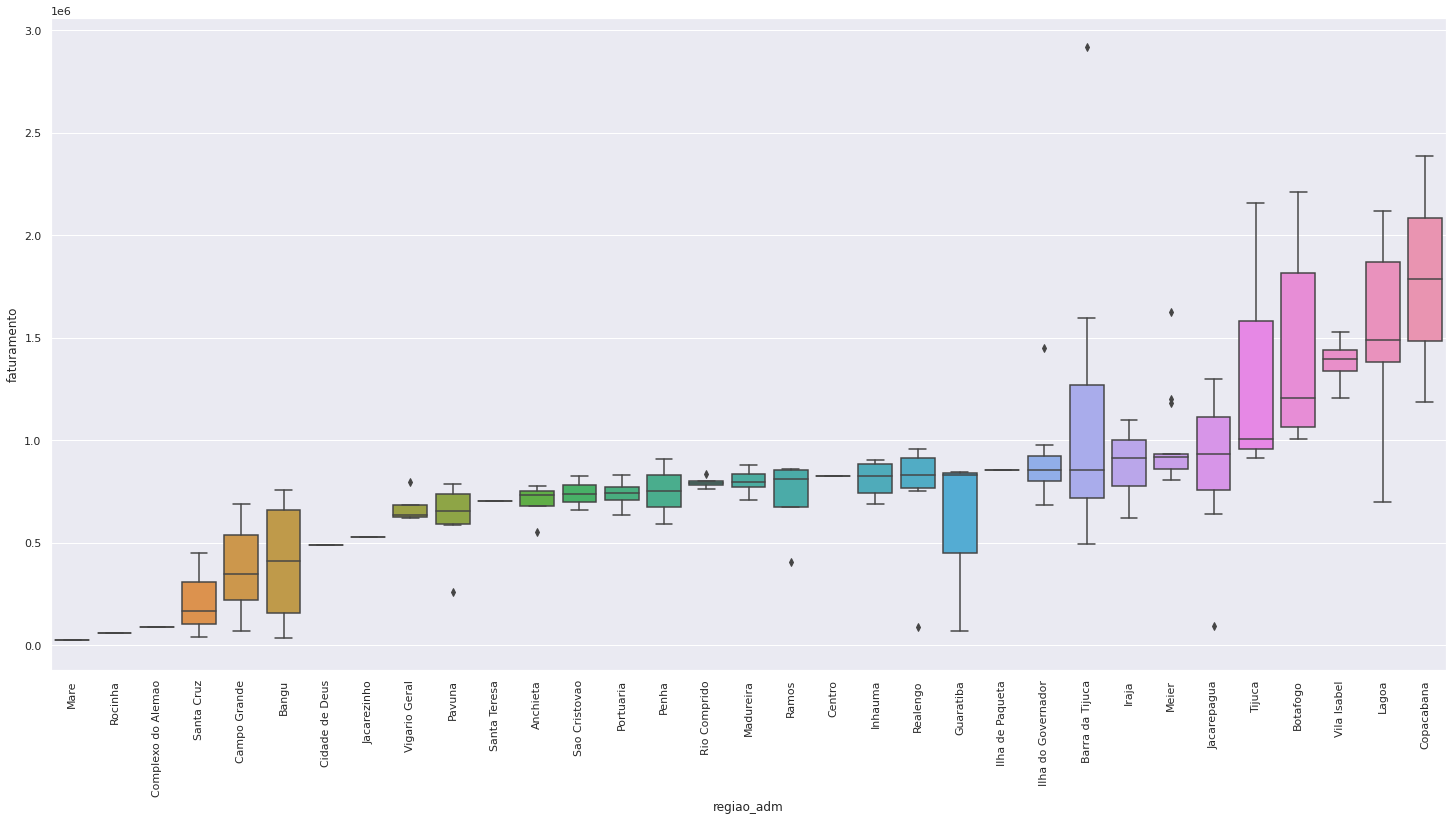

In [106]:
# Criando um df auxiliar para agrupar os valores pela mediana
aux = df1[['regiao_adm', 'faturamento']].groupby('regiao_adm').median().reset_index().sort_values(by = 'faturamento',
                                                                                                        ascending=True)
# plot boxplot
sns.boxplot(x='regiao_adm', y='faturamento', data=df1, order = aux['regiao_adm'].to_list())

# Rotacionando os valores X
plt.xticks(rotation=90);

## 3.2. Analise Bivariada

### H1. IDH Bairro x Faturamento
- O IDH do bairro e o Faturamento possuem boa correlação;
- IDH's mais elevados dos bairros são acompanhados, em boa parte dos casos, de maiores faturamentos.

In [107]:
# criando auxiliar para plotar categorias de idh por faturamento
aux = df3.loc[:, ['idh', 'faturamento']]
aux['idh'] = pd.cut(df3['idh'], bins=5)
aux_2 = aux.groupby('idh').mean().reset_index()

<AxesSubplot:>

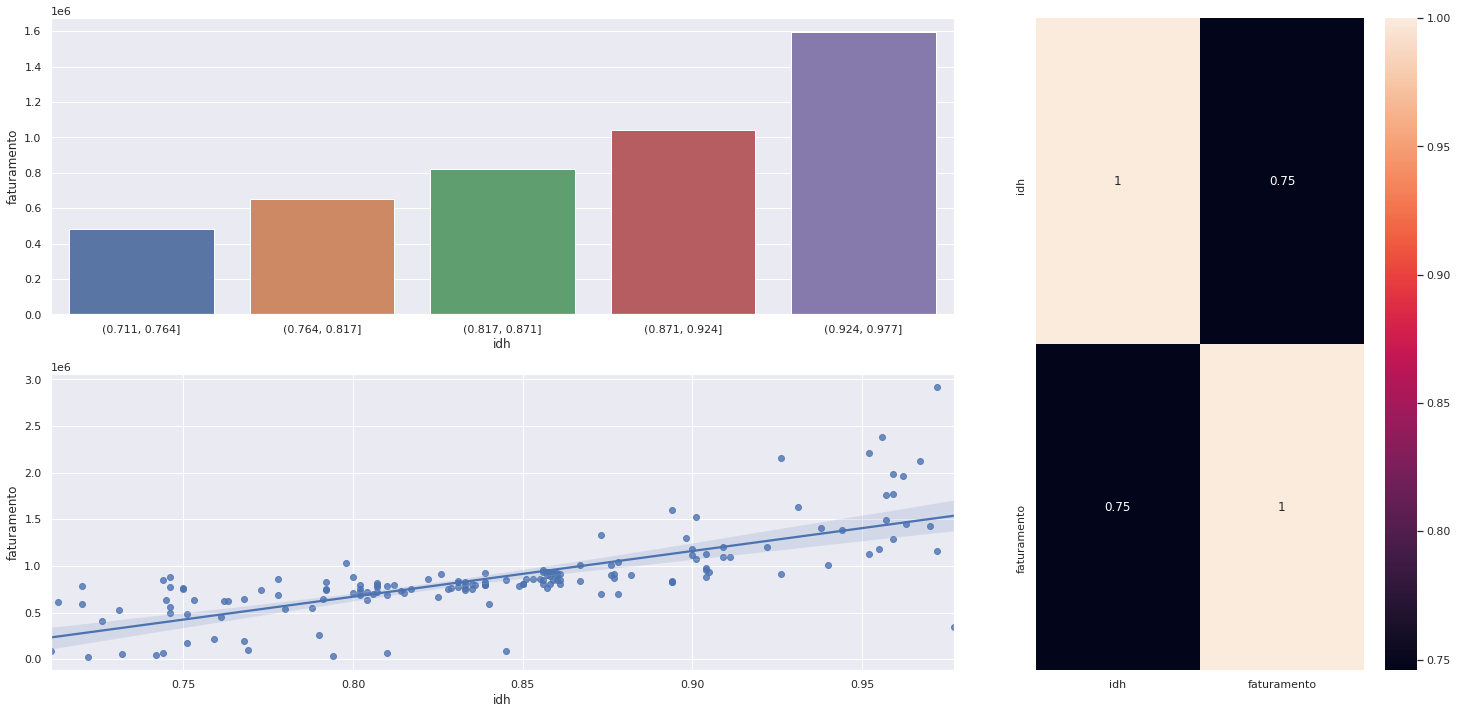

In [108]:
grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, :2])
# plot barplot categorias
sns.barplot(x='idh', y='faturamento', data=aux_2)

plt.subplot(grid[1, :2])
# plot regressão entre idh e faturamento
sns.regplot(x='idh', y='faturamento', data=df3)

plt.subplot(grid[:, 2])
# plot correlacao entre as variáveis idh e faturamentop
sns.heatmap(df3[['idh', 'faturamento']].corr(method='pearson'), annot=True)

### H2. IDH Subprefeitura x Faturamento
- O IDH da Subprefeitura e o Faturamento possuem uma correlação interessante;
- IDH's mais elevados das Subprefeituras são acompanhados, em boa parte dos casos, de maiores faturamentos.

In [109]:
# criando auxiliar para plotar categorias de idh por faturamento
aux = df3.loc[:, ['idh_subprefeitura', 'faturamento']]
aux['idh_subprefeitura'] = pd.cut(df3['idh_subprefeitura'], bins=3)
aux_2 = aux.groupby('idh_subprefeitura').mean().reset_index()

<AxesSubplot:>

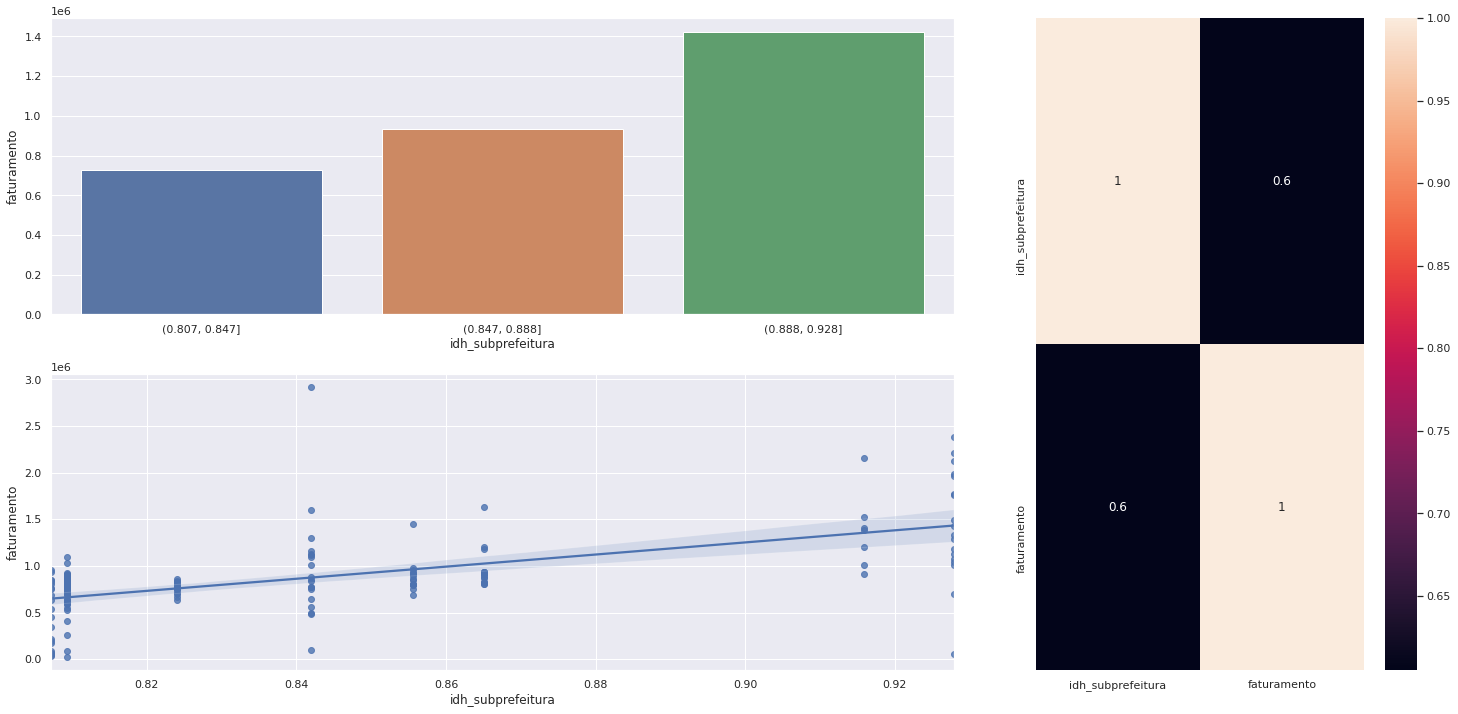

In [110]:
grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, :2])
# plot barplot categorias
sns.barplot(x='idh_subprefeitura', y='faturamento', data=aux_2)

plt.subplot(grid[1, :2])
# plot regressão entre idh e faturamento
sns.regplot(x='idh_subprefeitura', y='faturamento', data=df3)

plt.subplot(grid[:, 2])
# plot correlacao entre as variáveis idh e faturamento
sns.heatmap(df3[['idh_subprefeitura', 'faturamento']].corr(method='pearson'), annot=True)

### **H3.** Densidade Bairro x Faturamento
 - A Densidade do Bairro e o Faturamento possuem uma baixa correlação.

In [111]:
# criando auxiliar para plotar categorias de idh por faturamento
aux = df3.loc[:, ['densidade_bairro', 'faturamento']]
aux['densidade_bairro'] = pd.cut(df3['densidade_bairro'], bins=3)
aux_2 = aux.groupby('densidade_bairro').mean().reset_index()

<AxesSubplot:>

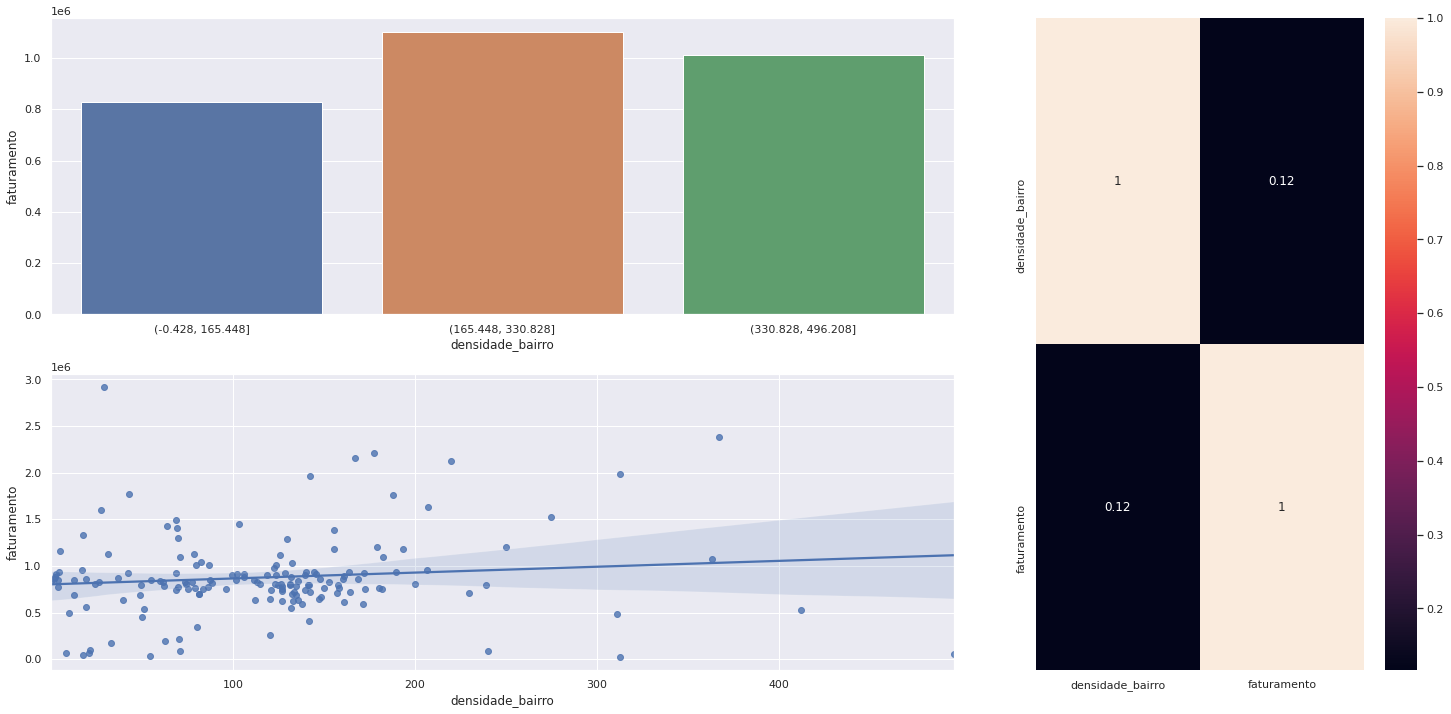

In [112]:
grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, :2])
# plot barplot categorias
sns.barplot(x='densidade_bairro', y='faturamento', data=aux_2)

plt.subplot(grid[1, :2])
# plot regressão entre idh e faturamento
sns.regplot(x='densidade_bairro', y='faturamento', data=df3)

plt.subplot(grid[:, 2])
# plot correlacao entre as variáveis idh e faturamento
sns.heatmap(df3[['densidade_bairro', 'faturamento']].corr(method='pearson'), annot=True)

### H4. Densidade Subprefeitura x Faturamento
 - A Densidade da Subprefeitura e o Faturamento possuem uma baixa correlação.

In [113]:
# criando auxiliar para plotar categorias de idh por faturamento
aux = df3.loc[:, ['densidade_subprefeitura', 'faturamento']]
aux['densidade_subprefeitura'] = pd.cut(df3['densidade_subprefeitura'], bins=3)
aux_2 = aux.groupby('densidade_subprefeitura').mean().reset_index()

<AxesSubplot:>

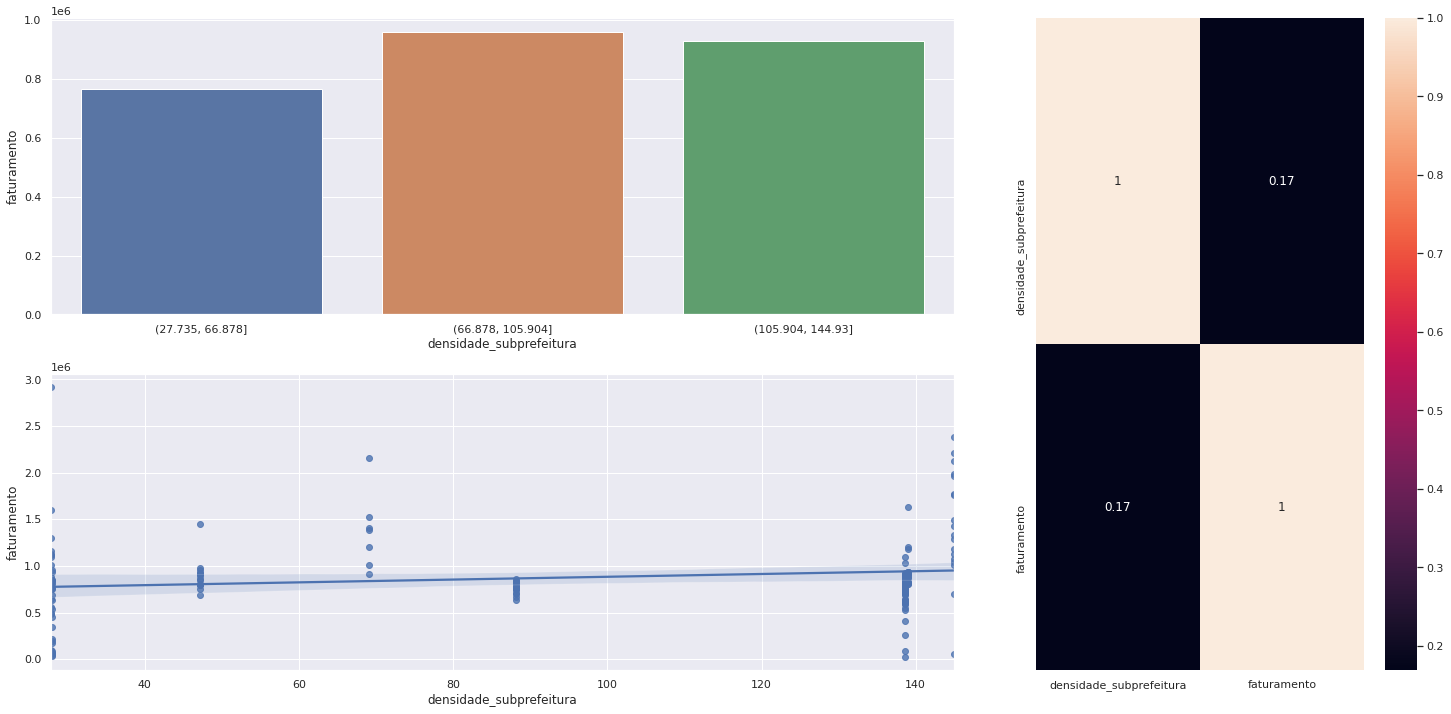

In [114]:
grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, :2])
# plot barplot categorias
sns.barplot(x='densidade_subprefeitura', y='faturamento', data=aux_2)

plt.subplot(grid[1, :2])
# plot regressão entre idh e faturamento
sns.regplot(x='densidade_subprefeitura', y='faturamento', data=df3)

plt.subplot(grid[:, 2])
# plot correlacao entre as variáveis idh e faturamento
sns.heatmap(df3[['densidade_subprefeitura', 'faturamento']].corr(method='pearson'), annot=True)

### H5. Renda Total Bairro x Faturamento
- Existe alguma correlação entre a Renda total do Bairro e o Faturamento;
- Valores altos de renda(que sao outliers) possuem valores de faturamento superior.

In [115]:
# Selecionando valores inferiores aos outliers
aux_1 = df3.loc[df3['renda_abs_bairro'] < 300000000, :]

<AxesSubplot:>

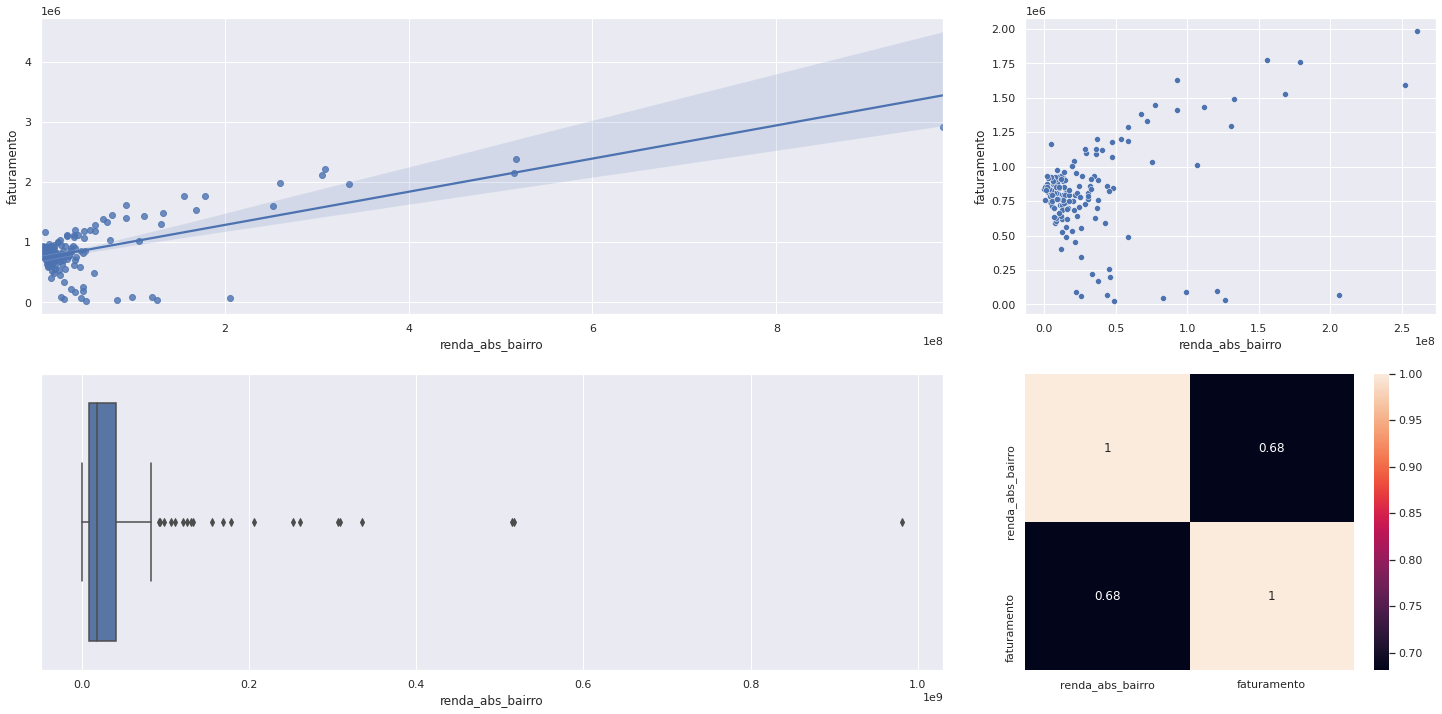

In [116]:
grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, :2])
# plot regressão incluindo outliers
sns.regplot(x='renda_abs_bairro', y='faturamento', data=df3)

plt.subplot(grid[1, :2])
# plot boxplot renda absoluta
sns.boxplot(x = df3['renda_abs_bairro'])

plt.subplot(grid[0, 2])
# plot scatterplot renda absoluta sem outliers
sns.scatterplot(x='renda_abs_bairro', y='faturamento', data=aux_1)

plt.subplot(grid[1, 2])
# plot heatmap de correlação
sns.heatmap(df3[['renda_abs_bairro', 'faturamento']].corr(method='pearson'), annot=True)

### H6. Renda Média Bairro x Faturamento
- Existe alguma correlação entre a Renda Média do Bairro e o faturamento;
- Valores altos de renda possuem valores de faturamento superior.

In [117]:
# Selecionando valores inferiores aos outliers
aux_1 = df3.loc[df3['renda_abs_bairro'] < 300000000, :]

<AxesSubplot:>

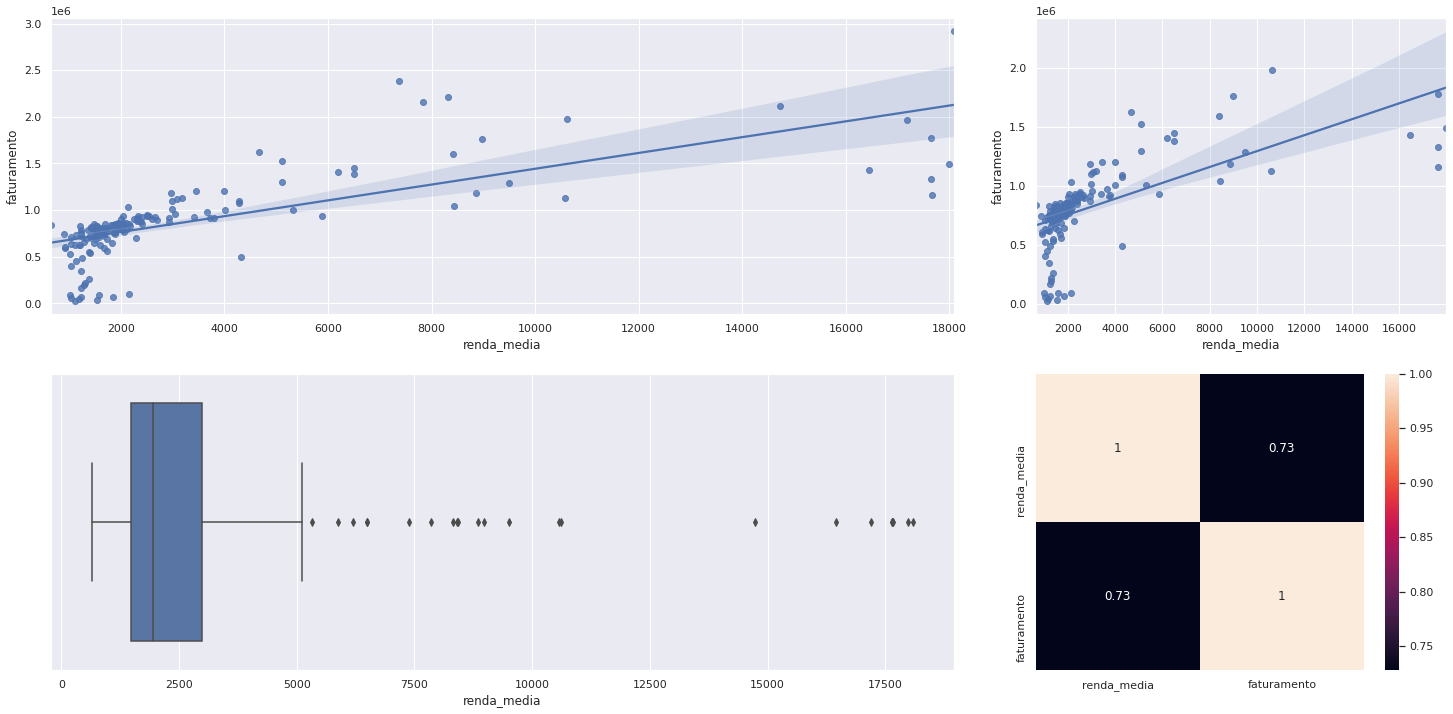

In [118]:
grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, :2])
# plot regressão incluindo outliers
sns.regplot(x='renda_media', y='faturamento', data=df3)

plt.subplot(grid[1, :2])
# plot boxplot renda absoluta
sns.boxplot(x = df3['renda_media'])

plt.subplot(grid[0, 2])
# plot scatterplot renda absoluta sem outliers
sns.regplot(x='renda_media', y='faturamento', data=aux_1)

plt.subplot(grid[1, 2])
# plot heatmap de correlação
sns.heatmap(df3[['renda_media', 'faturamento']].corr(method='pearson'), annot=True)

### H7. Renda Total Subprefeitura x Faturamento
- A correlação entre a Renda bruta por Subprefeitura e o faturamento é mínima.

In [119]:
df3['renda_abs_subprefeitura'] = df3['renda_media_subprefeitura'] * df3['populacao_subprefeitura']

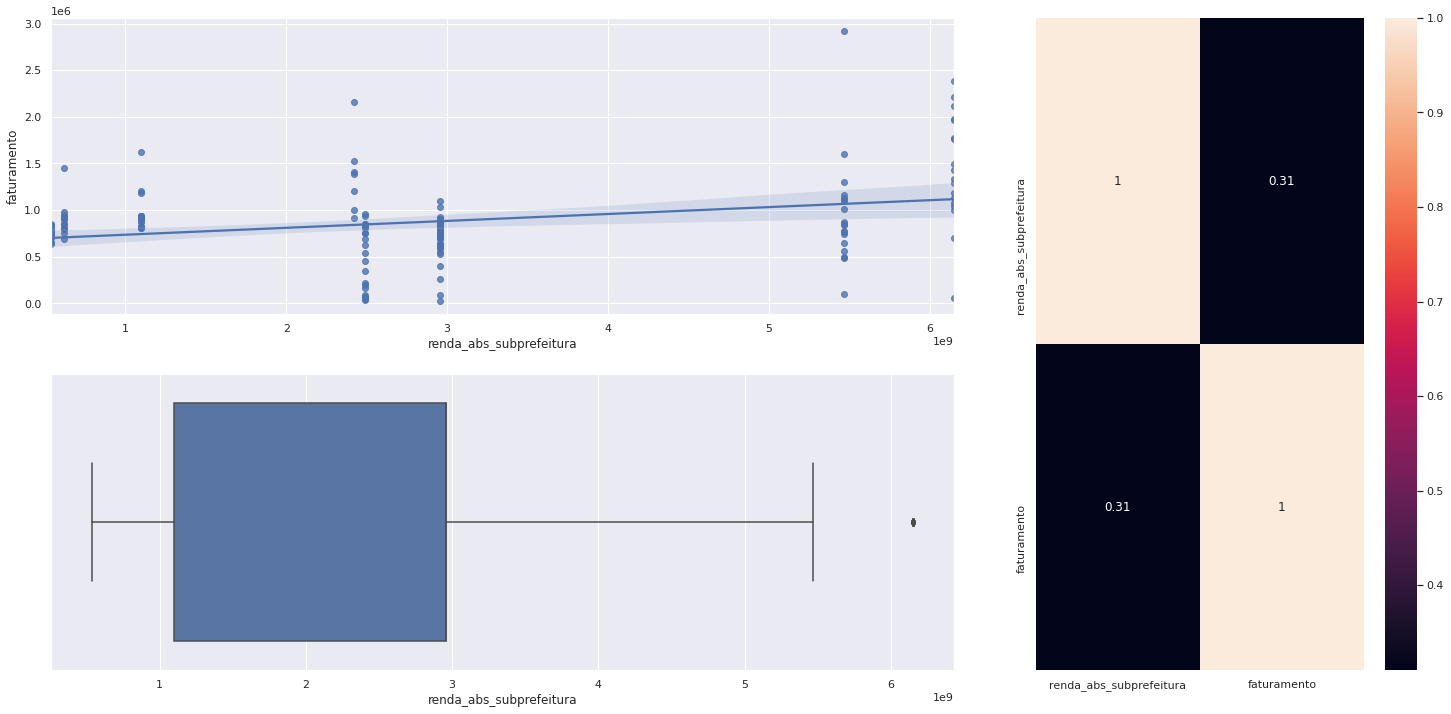

In [120]:
grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, :2])
# plot regressão incluindo
sns.regplot(x='renda_abs_subprefeitura', y='faturamento', data=df3)

plt.subplot(grid[1, :2])
# plot boxplot renda absoluta
sns.boxplot(x = df3['renda_abs_subprefeitura'])

plt.subplot(grid[:, 2])
# plot heatmap de correlação
sns.heatmap(df3[['renda_abs_subprefeitura', 'faturamento']].corr(method='pearson'), annot=True)

df3 = df3.drop('renda_abs_subprefeitura', axis=1)

### H8. Renda Média Subprefeitura x Faturamento
- Existe alguma correlação entre a Renda média da subprefeitura e o faturamento;
- Valores altos de renda possuem valores de faturamento superior.

<AxesSubplot:>

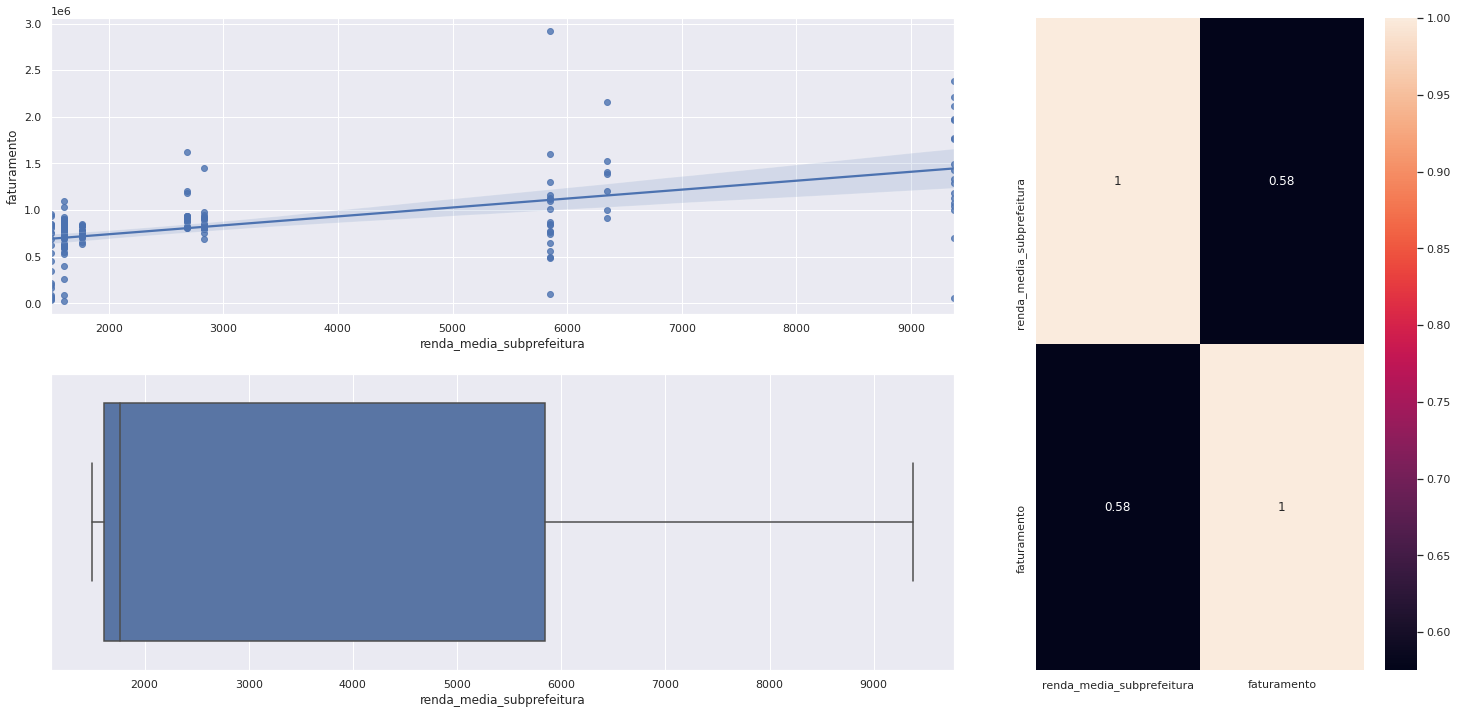

In [121]:
grid = plt.GridSpec(2, 3)

plt.subplot(grid[0, :2])
# plot regressão incluindo
sns.regplot(x='renda_media_subprefeitura', y='faturamento', data=df3)

plt.subplot(grid[1, :2])
# plot boxplot renda absoluta
sns.boxplot(x = df3['renda_media_subprefeitura'])

plt.subplot(grid[:, 2])
# plot heatmap de correlação
sns.heatmap(df3[['renda_media_subprefeitura', 'faturamento']].corr(method='pearson'), annot=True)

### H9. Bairro x Faturamento - Top 10 Faturamentos - Bairros

In [122]:
# Criando auxiliar comos valores de faturamento ordenados do maior para o menos (os 10 primeiros)
aux = df3.sort_values(by='faturamento', ascending=True).iloc[-10:, :]

<AxesSubplot:xlabel='nome', ylabel='faturamento'>

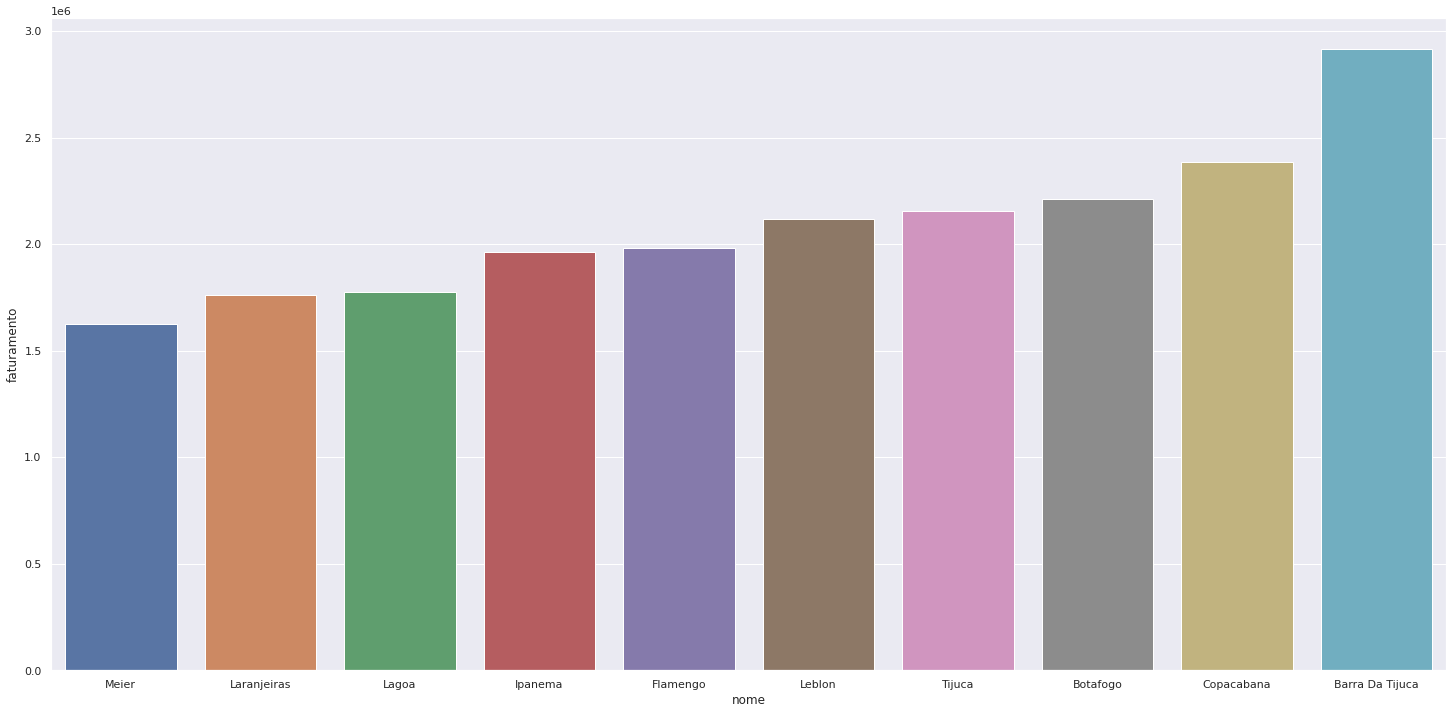

In [123]:
# plot barplot dos maiores faturamentos
sns.barplot(x='nome', y='faturamento', data=aux)

### H10. Região Adm x Faturamento - Top 10 Faturamentos - Região Administrativa

In [124]:
# Regioes com maior faturamento - Absoluto
aux = df3[['regiao_adm', 'faturamento']].groupby('regiao_adm').sum().sort_values(by='faturamento').reset_index()
aux_2 = aux.loc[23:, :]

# Regioes com maior faturamento - Mediana
aux_3 = df3[['regiao_adm', 'faturamento']].groupby('regiao_adm').median().sort_values(by='faturamento').reset_index()
aux_4 = aux_3.loc[23:, :]

Text(0.5, 1.0, 'Top 10 Faturamento Mediano por Região Administrativa')

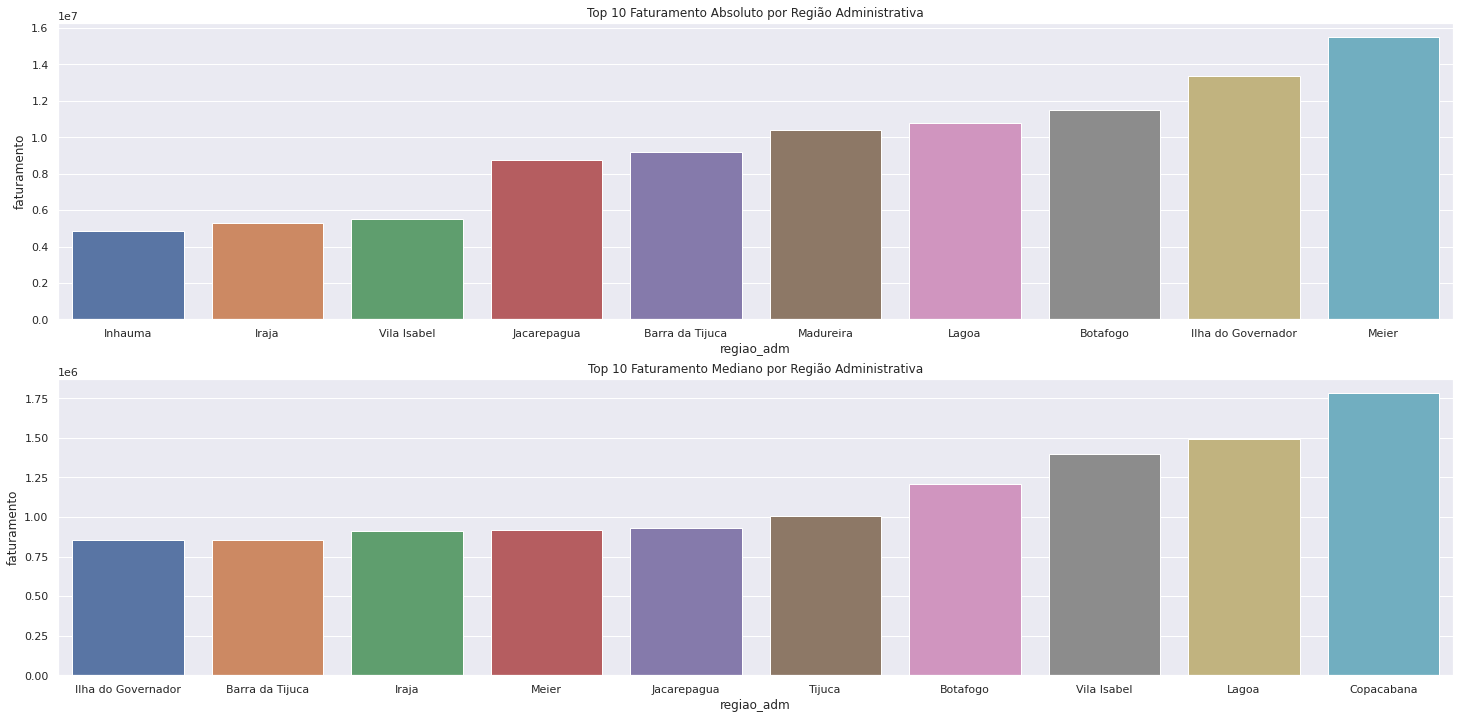

In [125]:
grid = plt.GridSpec(2, 1)

plt.subplot(grid[0, 0])
# plot rank de faturamento absoluto
sns.barplot(x='regiao_adm', y='faturamento', data=aux_2)
plt.title('Top 10 Faturamento Absoluto por Região Administrativa')

plt.subplot(grid[1, 0])
# plot rank de faturamento mediano
sns.barplot(x='regiao_adm', y='faturamento', data=aux_4)
plt.title('Top 10 Faturamento Mediano por Região Administrativa')

### H11. Subprefeitura x Faturamento Top 10 Faturamentos - Subprefeitura

In [126]:
# Regioes com maior faturamento - Absoluto
aux = df3[['subprefeitura', 'faturamento']].groupby('subprefeitura').sum().sort_values(by='faturamento').reset_index()

# Regioes com maior faturamento - Mediana
aux_2 = df3[['subprefeitura', 'faturamento']].groupby('subprefeitura').median().sort_values(by='faturamento').reset_index()

Text(0.5, 1.0, 'Top 10 Faturamento Mediano por Subprefeitura')

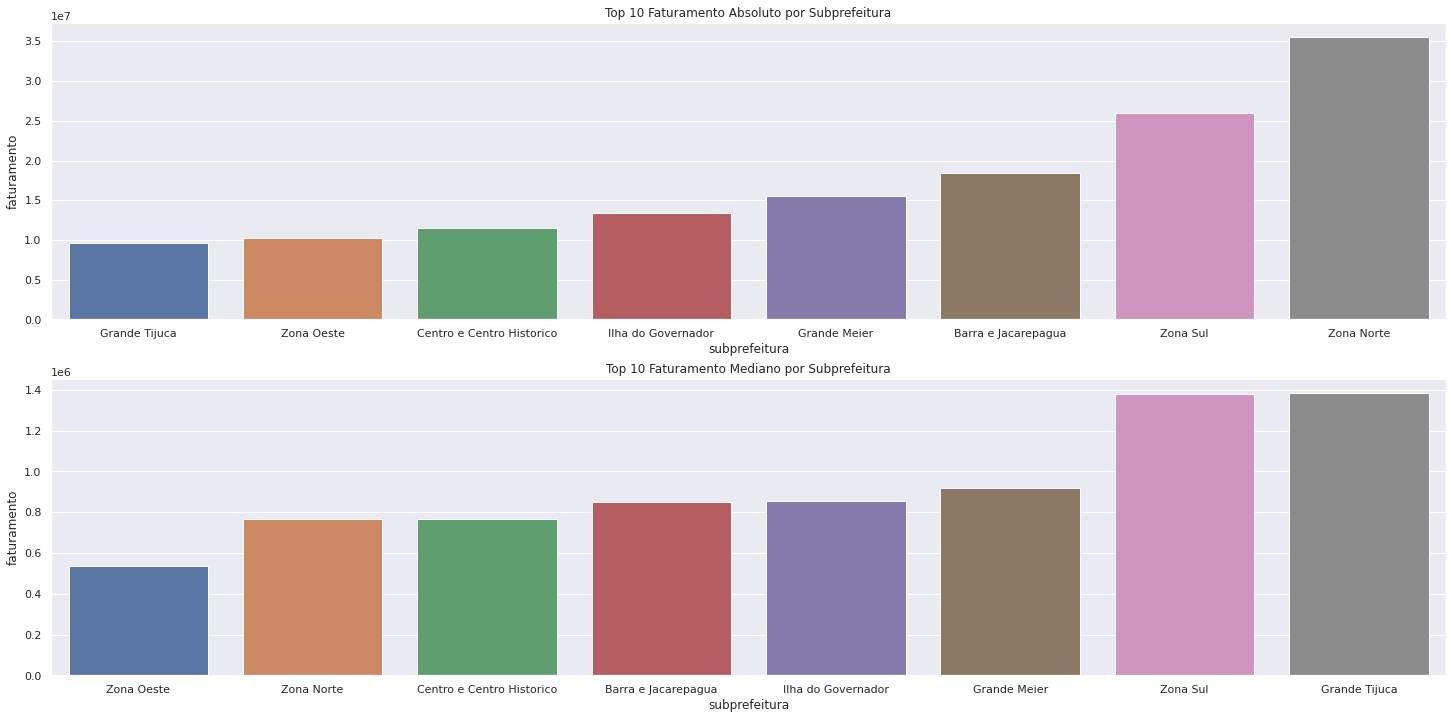

In [127]:
grid = plt.GridSpec(2, 1)

plt.subplot(grid[0, 0])
# plot rank de faturamento absoluto
sns.barplot(x='subprefeitura', y='faturamento', data=aux)
plt.title('Top 10 Faturamento Absoluto por Subprefeitura')

plt.subplot(grid[1, 0])
# plot rank de faturamento mediano
sns.barplot(x='subprefeitura', y='faturamento', data=aux_2)
plt.title('Top 10 Faturamento Mediano por Subprefeitura')

### H12. Idade Total Bairro x Faturamento
- Em bairros onde a porcentagem de pessoas mais velhas é superior, o faturamento é maior.
- Em bairros onde a porcentagem de pessoas mais jovens é superior, o faturamento é menor.

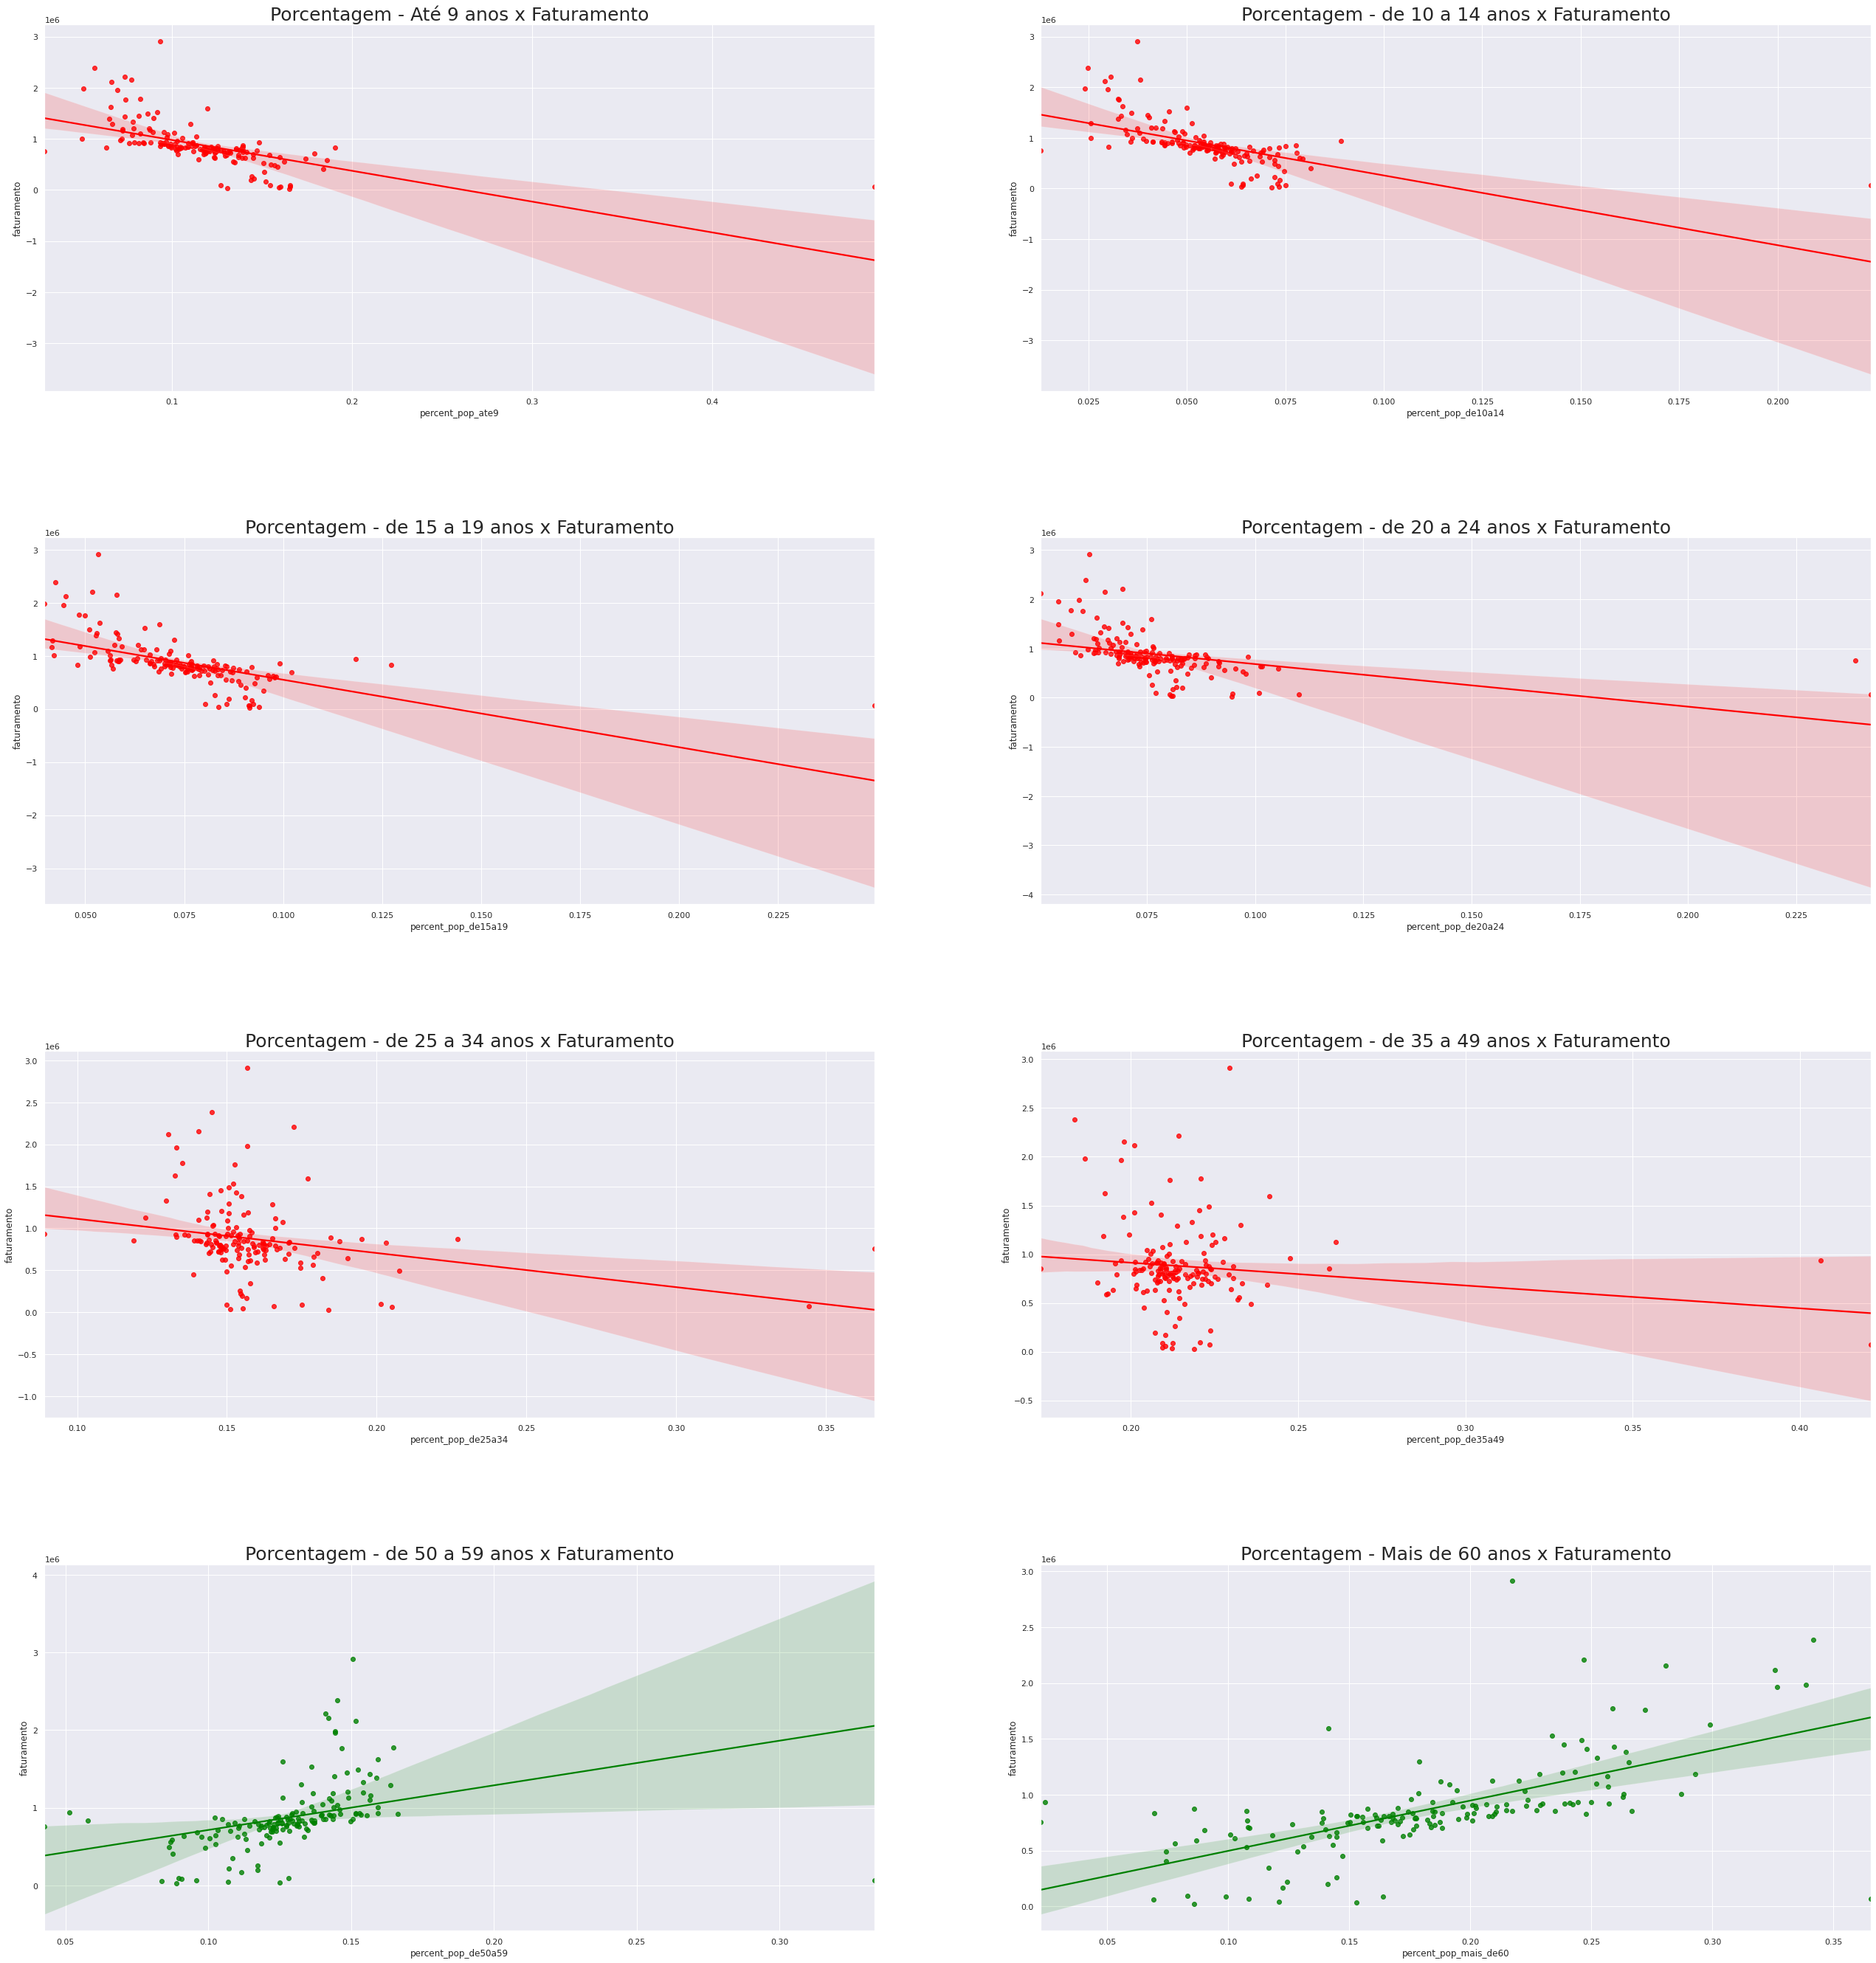

In [128]:
grid = plt.GridSpec(4, 2)

plt.subplot(grid[0, 0])
# Porcentagem - Até 9 anos x Faturamento
sns.regplot(x = df3['percent_pop_ate9'], y = df3['faturamento'], color='red')
plt.title('Porcentagem - Até 9 anos x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[0, 1])
# Porcentagem - de 10 a 14 anos x Faturamento
sns.regplot(x = df3['percent_pop_de10a14'], y = df3['faturamento'], color='red')
plt.title('Porcentagem - de 10 a 14 anos x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[1, 0])
# Porcentagem - de 15 a 19 anos x Faturamento
sns.regplot(x = df3['percent_pop_de15a19'], y = df3['faturamento'], color='red')
plt.title('Porcentagem - de 15 a 19 anos x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[1, 1])
# Porcentagem - de 20 a 24 anos x Faturamento
sns.regplot(x = df3['percent_pop_de20a24'], y = df3['faturamento'], color='red')
plt.title('Porcentagem - de 20 a 24 anos x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[2, 0])
# Porcentagem - de 25 a 34 anos x Faturamento
sns.regplot(x = df3['percent_pop_de25a34'], y = df3['faturamento'], color='red')
plt.title('Porcentagem - de 25 a 34 anos x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[2, 1])
# Porcentagem - de 35 a 49 anos x Faturamento
sns.regplot(x = df3['percent_pop_de35a49'], y = df3['faturamento'], color='red')
plt.title('Porcentagem - de 35 a 49 anos x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[3, 0])
# Porcentagem - de 50 a 59 anos x Faturamento
sns.regplot(x = df3['percent_pop_de50a59'], y = df3['faturamento'], color='green')
plt.title('Porcentagem - de 50 a 59 anos x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[3, 1])
# Porcentagem - Mais de 60 anos x Faturamento
sns.regplot(x = df3['percent_pop_mais_de60'], y = df3['faturamento'], color='green')
plt.title('Porcentagem - Mais de 60 anos x Faturamento', fontdict={'fontsize':25})

# Ajuste subplots
plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=1.5, 
                    top=3, 
                    wspace=0.2, 
                    hspace=0.40)

Text(0.5, 1.0, 'Faturamento por percentual de idade 50+')

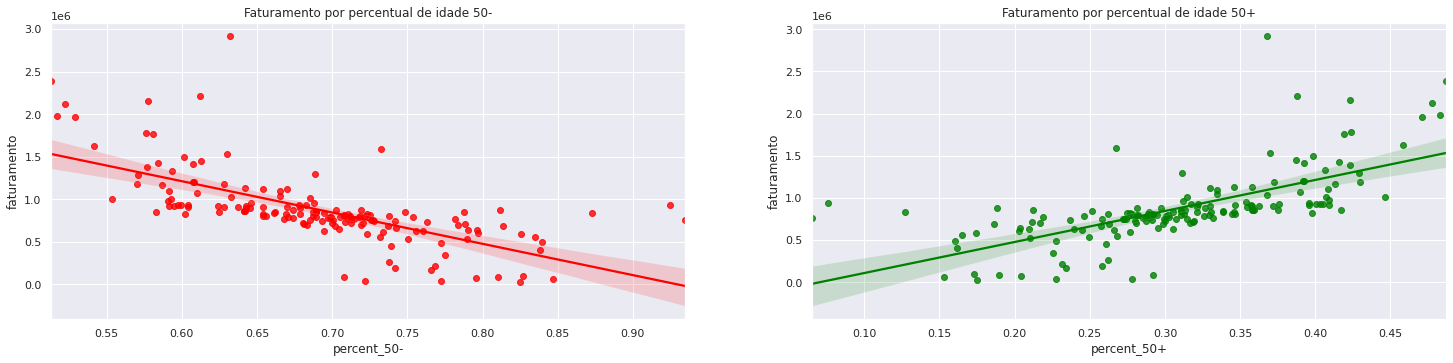

In [129]:
grid = plt.GridSpec(2, 2)

# Auxiliar sem o bairro de Campo Grande
aux = df2.drop(df2[df2['nome'] == 'Campo Grande'].index, axis=0)

plt.subplot(grid[0, 0])
# Plot regplot percent - 50
sns.regplot(x = aux['percent_50-'], y = aux['faturamento'], color='red')
plt.title('Faturamento por percentual de idade 50-')

plt.subplot(grid[0, 1])
# Plot regplot percent + 50
sns.regplot(x = aux['percent_50+'], y = aux['faturamento'], color='green')
plt.title('Faturamento por percentual de idade 50+')

### H13. Domicílio Bairro x Faturamento
- Maior Faturamento em bairros com porcentagem de Domicílios A e B superior
- Menor Faturamento em bairros com porcentagem de Domicílios C, D e E superior

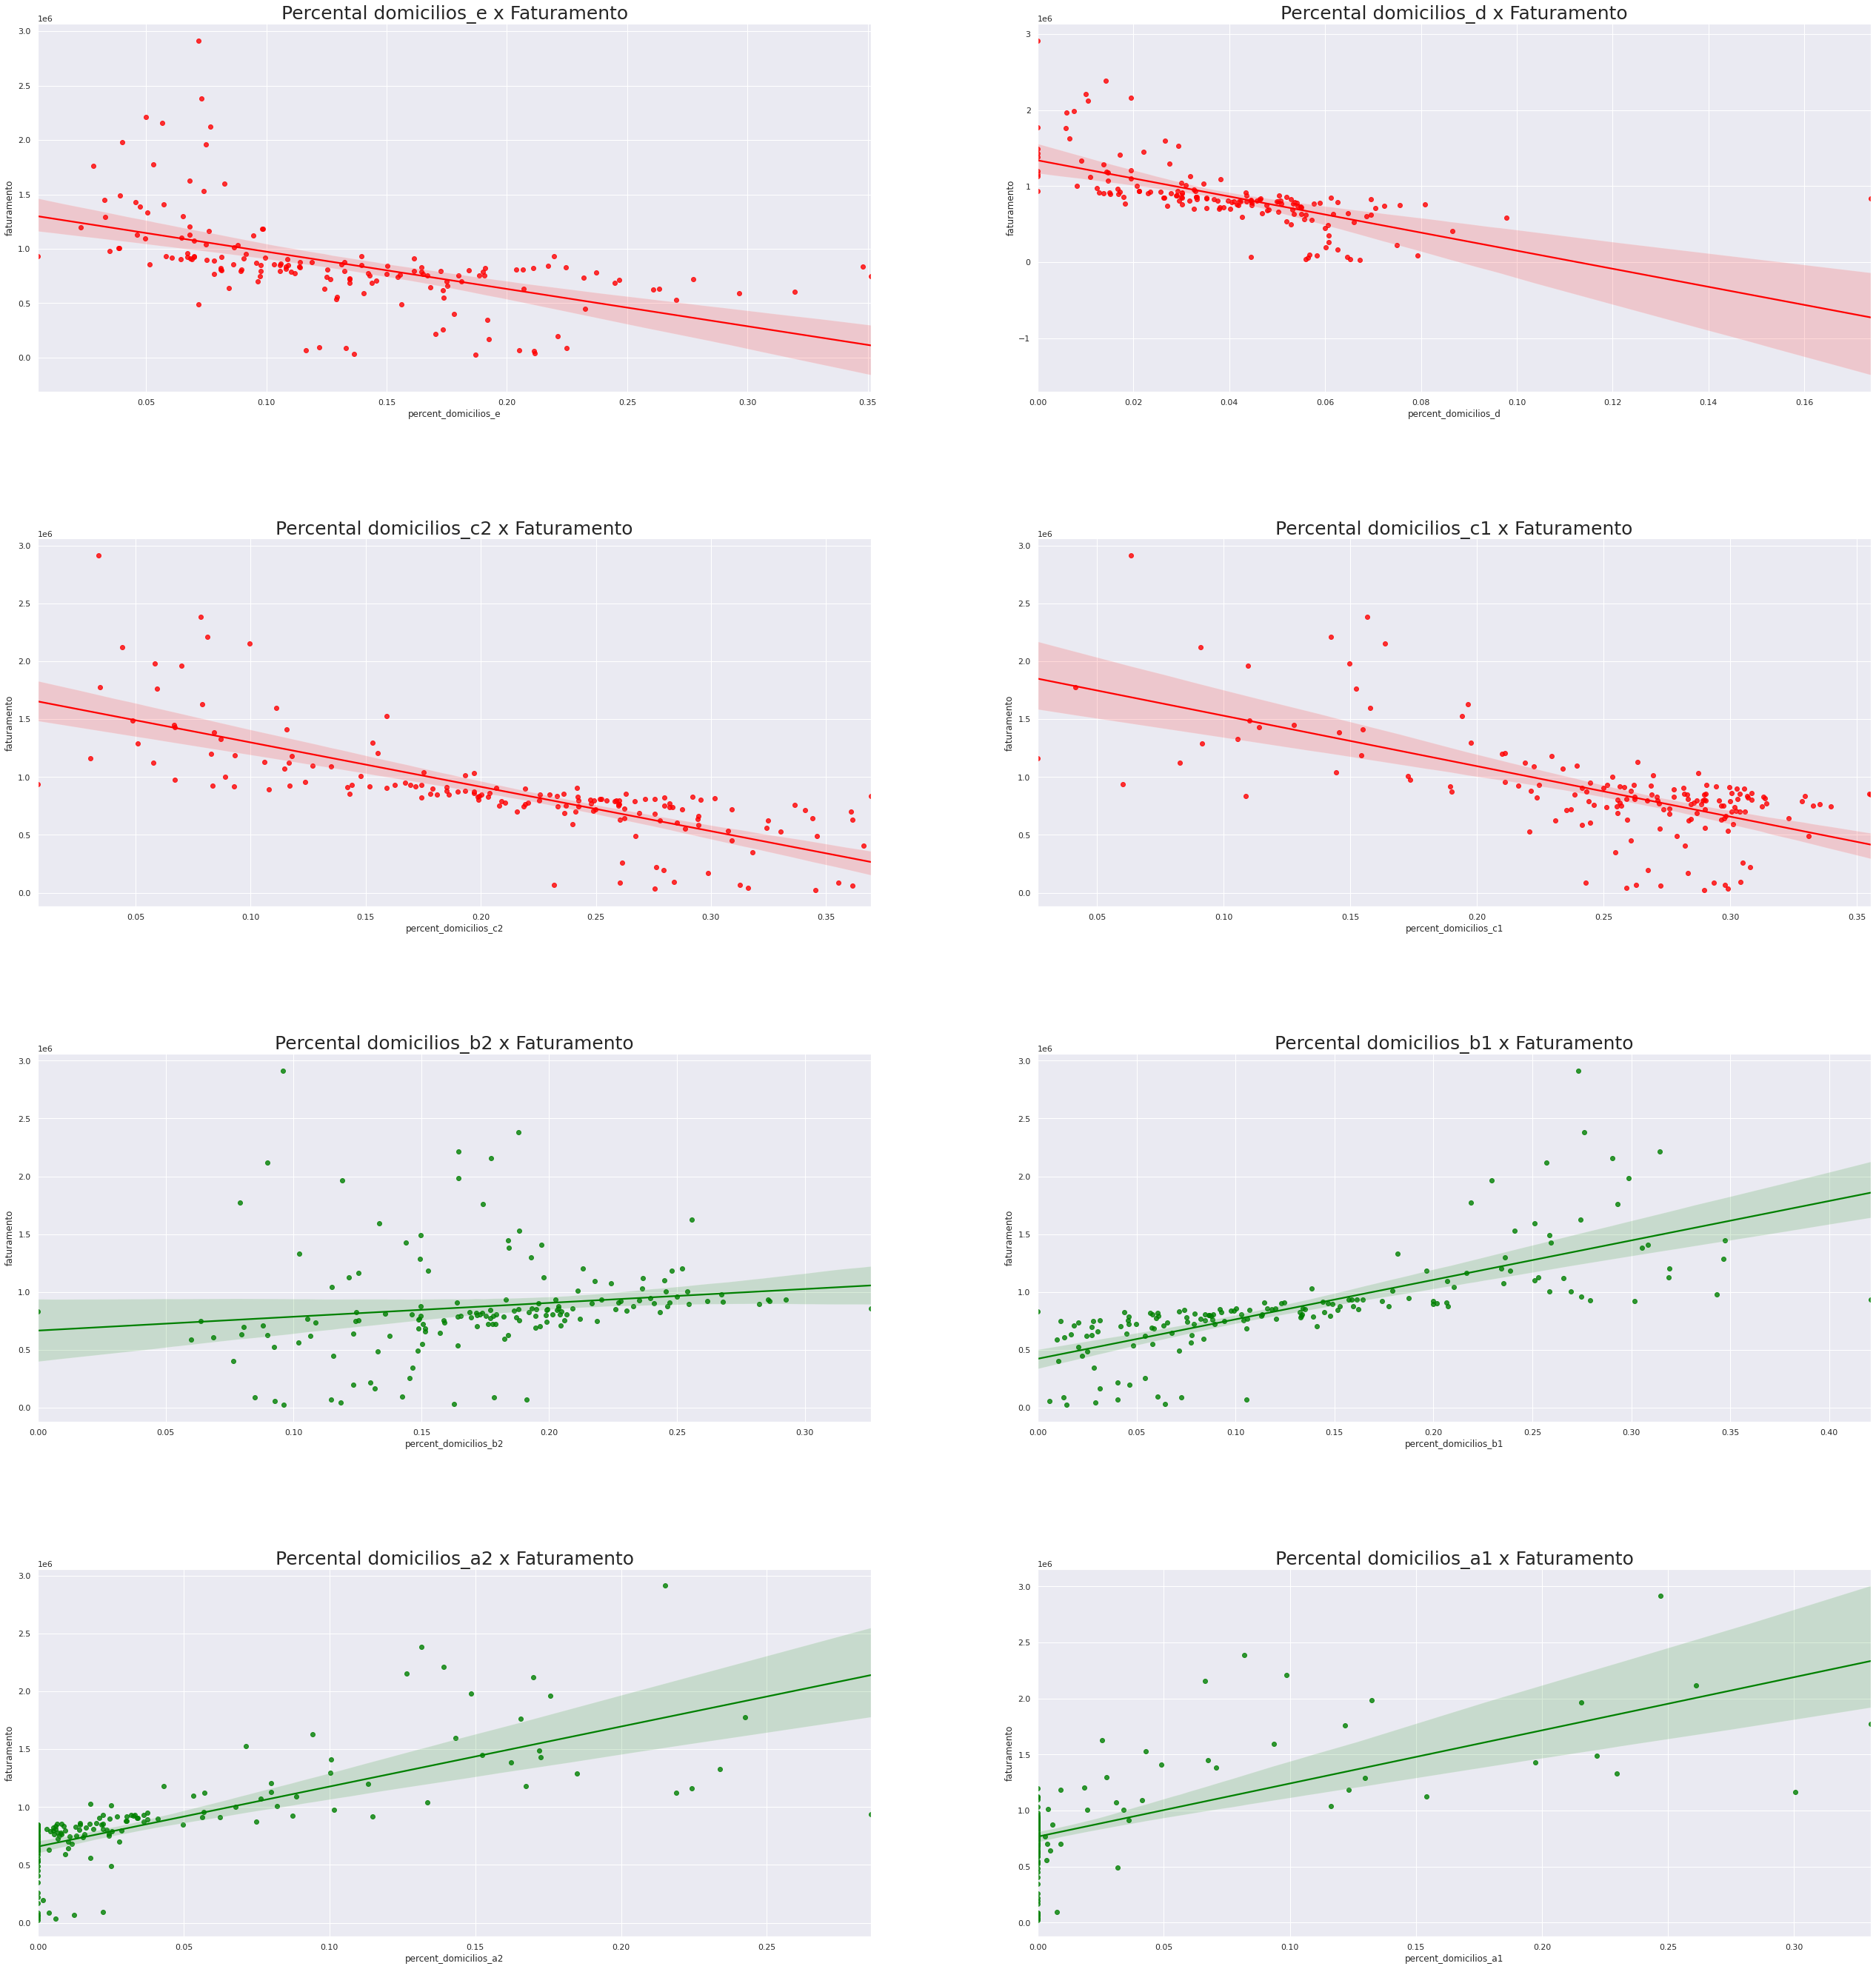

In [130]:
grid = plt.GridSpec(4, 2)

plt.subplot(grid[0, 0])
# Percentual - domicilios_e x Faturamento
sns.regplot(x = df3['percent_domicilios_e'], y = df3['faturamento'], color='red')
plt.title('Percental domicilios_e x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[0, 1])
# Percentual - domicilios_d x Faturamento
sns.regplot(x = df3['percent_domicilios_d'], y = df3['faturamento'], color='red')
plt.title('Percental domicilios_d x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[1, 0])
# Percentual - domicilios_c2 x Faturamento
sns.regplot(x = df3['percent_domicilios_c2'], y = df3['faturamento'], color='red')
plt.title('Percental domicilios_c2 x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[1, 1])
# Percentual - domicilios_c1 x Faturamento
sns.regplot(x = df3['percent_domicilios_c1'], y = df3['faturamento'], color='red')
plt.title('Percental domicilios_c1 x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[2, 0])
# Percentual - domicilios_b2 x Faturamento
sns.regplot(x = df3['percent_domicilios_b2'], y = df3['faturamento'], color='green')
plt.title('Percental domicilios_b2 x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[2, 1])
# Percentual - domicilios_b1 x Faturamento
sns.regplot(x = df3['percent_domicilios_b1'], y = df3['faturamento'], color='green')
plt.title('Percental domicilios_b1 x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[3, 0])
# Percentual - domicilios_a2 x Faturamento
sns.regplot(x = df3['percent_domicilios_a2'], y = df3['faturamento'], color='green')
plt.title('Percental domicilios_a2 x Faturamento', fontdict={'fontsize':25})

plt.subplot(grid[3, 1])
# Percentual - domicilios_a1 x Faturamento
sns.regplot(x = df3['percent_domicilios_a1'], y = df3['faturamento'], color='green')
plt.title('Percental domicilios_a1 x Faturamento', fontdict={'fontsize':25})

# Ajuste subplots
plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=1.5, 
                    top=3, 
                    wspace=0.2, 
                    hspace=0.40)

Text(0.5, 1.0, 'Faturamento por percentual de Domicílios C, D e E')

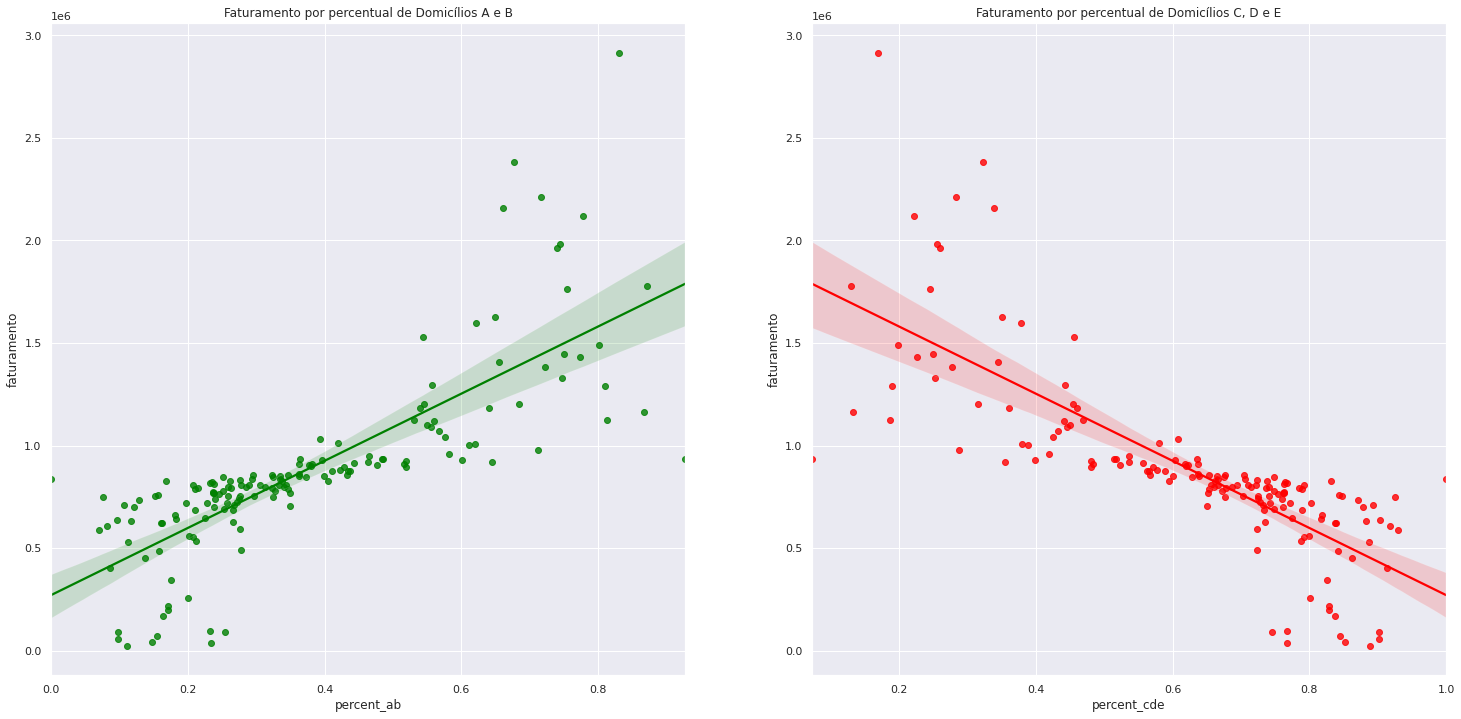

In [131]:
grid = plt.GridSpec(1, 2)

# Auxiliar sem o bairro de Campo Grande
aux = df2.drop(df2[df2['nome'] == 'Campo Grande'].index, axis=0)

plt.subplot(grid[0, 0])
# Plot regplot percent domicilios A e B
sns.regplot(x = aux['percent_ab'], y = aux['faturamento'], color='green')
plt.title('Faturamento por percentual de Domicílios A e B')

plt.subplot(grid[0, 1])
# Plot regplot percent domicilios C, D e E
sns.regplot(x = aux['percent_cde'], y = aux['faturamento'], color='red')
plt.title('Faturamento por percentual de Domicílios C, D e E')

### H14. População Absoluta Bairro x Faturamento
- Baixa correlação entre as variáveis

<AxesSubplot:>

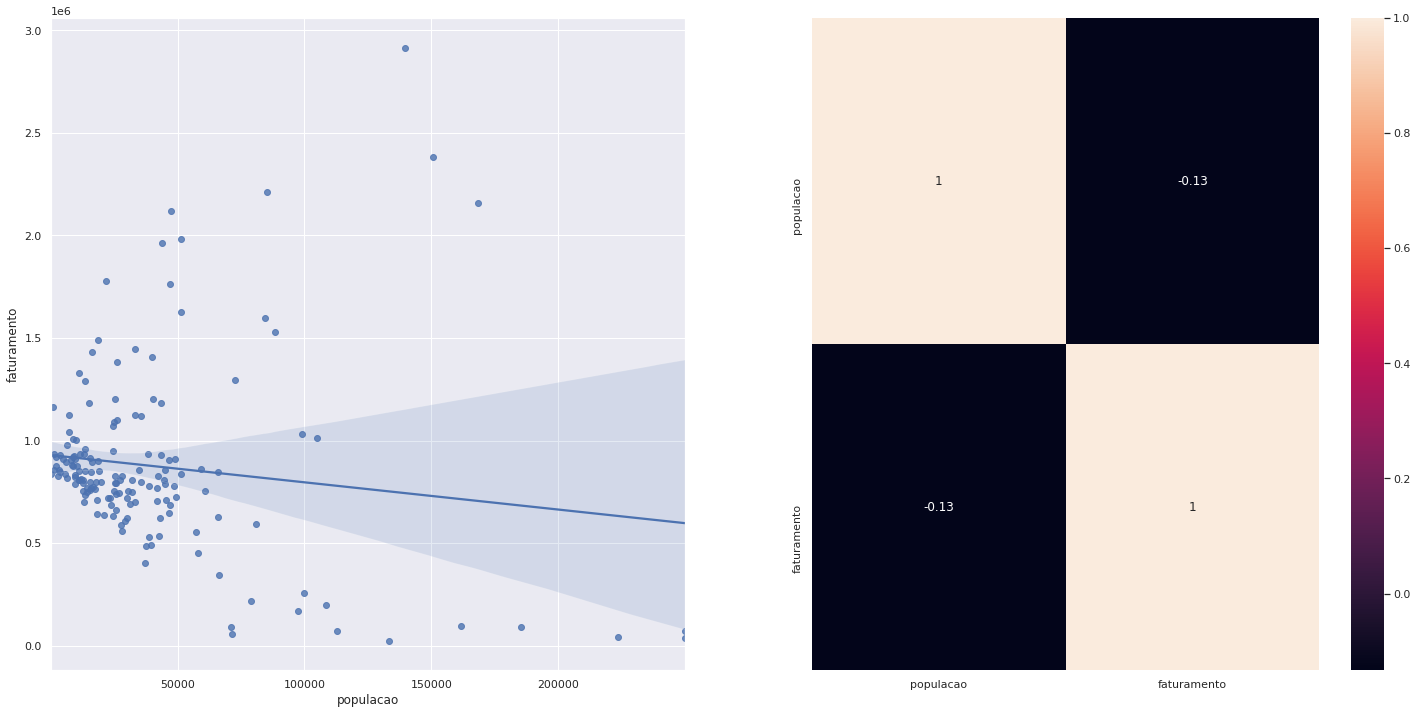

In [132]:
grid = plt.GridSpec(1, 2)

plt.subplot(grid[0, 0])
# Plot regressao do faturamento por populacao absoluta
sns.regplot(x='populacao', y='faturamento', data=df3)

# Plot correlacao entre faturamento e populacao absoluta
plt.subplot(grid[0, 1])
sns.heatmap(df3[['populacao', 'faturamento']].corr(method='pearson'), annot=True)

### H15. População Absoluta Subprefeitura x Faturamento
- A correlação entre as variáveis é baixa
- Entretanto, é possível perceber uma pequena tendência de redução de faturamento em subprefeituras mais populosas.

<AxesSubplot:>

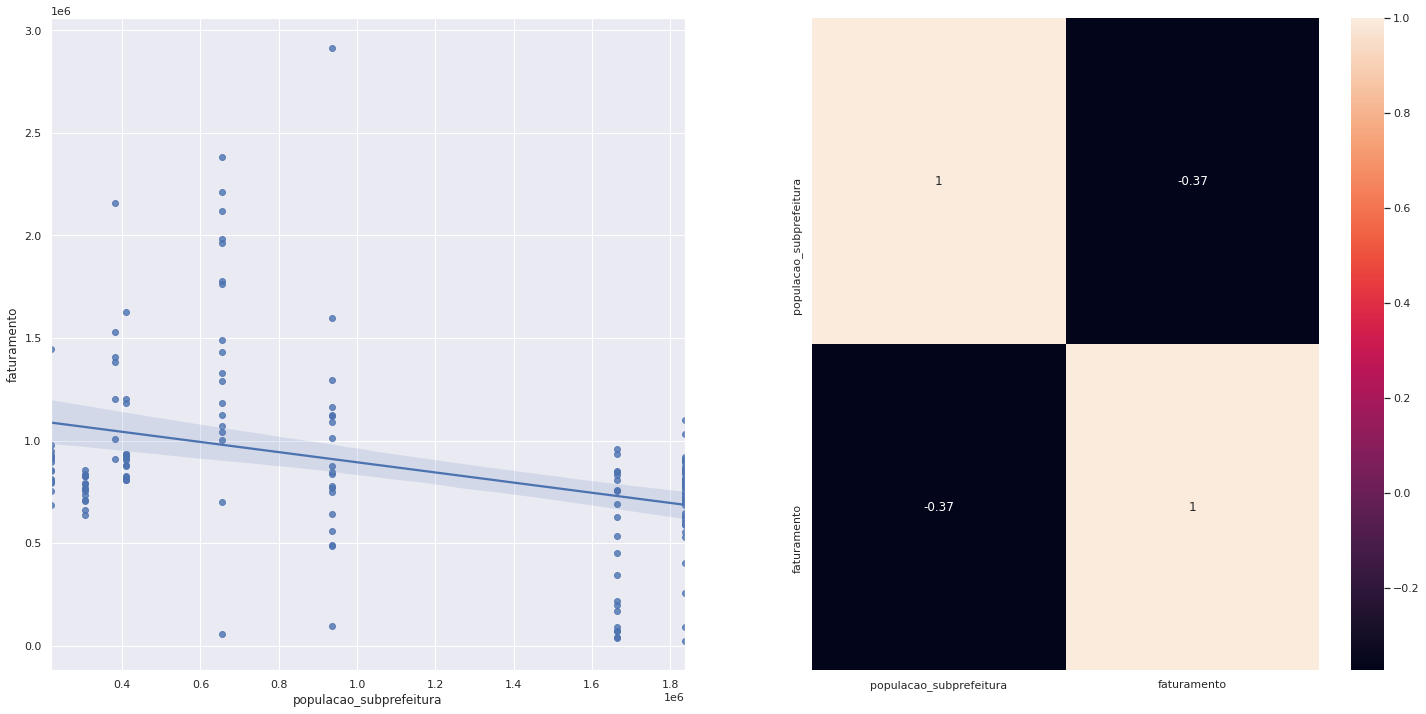

In [133]:
grid = plt.GridSpec(1, 2)

plt.subplot(grid[0, 0])
# Plot regressao do faturamento por populacao absoluta da subprefeitura
sns.regplot(x='populacao_subprefeitura', y='faturamento', data=df3)

plt.subplot(grid[0, 1])
# Plot correlacao entre faturamento e populacao absoluta da subprefeitura
sns.heatmap(df3[['populacao_subprefeitura', 'faturamento']].corr(method='pearson'), annot=True)

## 3.3. Analise Multivariada

In [134]:
# Separando atributos numericos
num_attributes = df3.select_dtypes(include=['float64', 'int64'])

# Excluindo o codigo
num_attributes = num_attributes.drop('codigo', axis=1)

### 3.3.1. Numerical Variables

<AxesSubplot:>

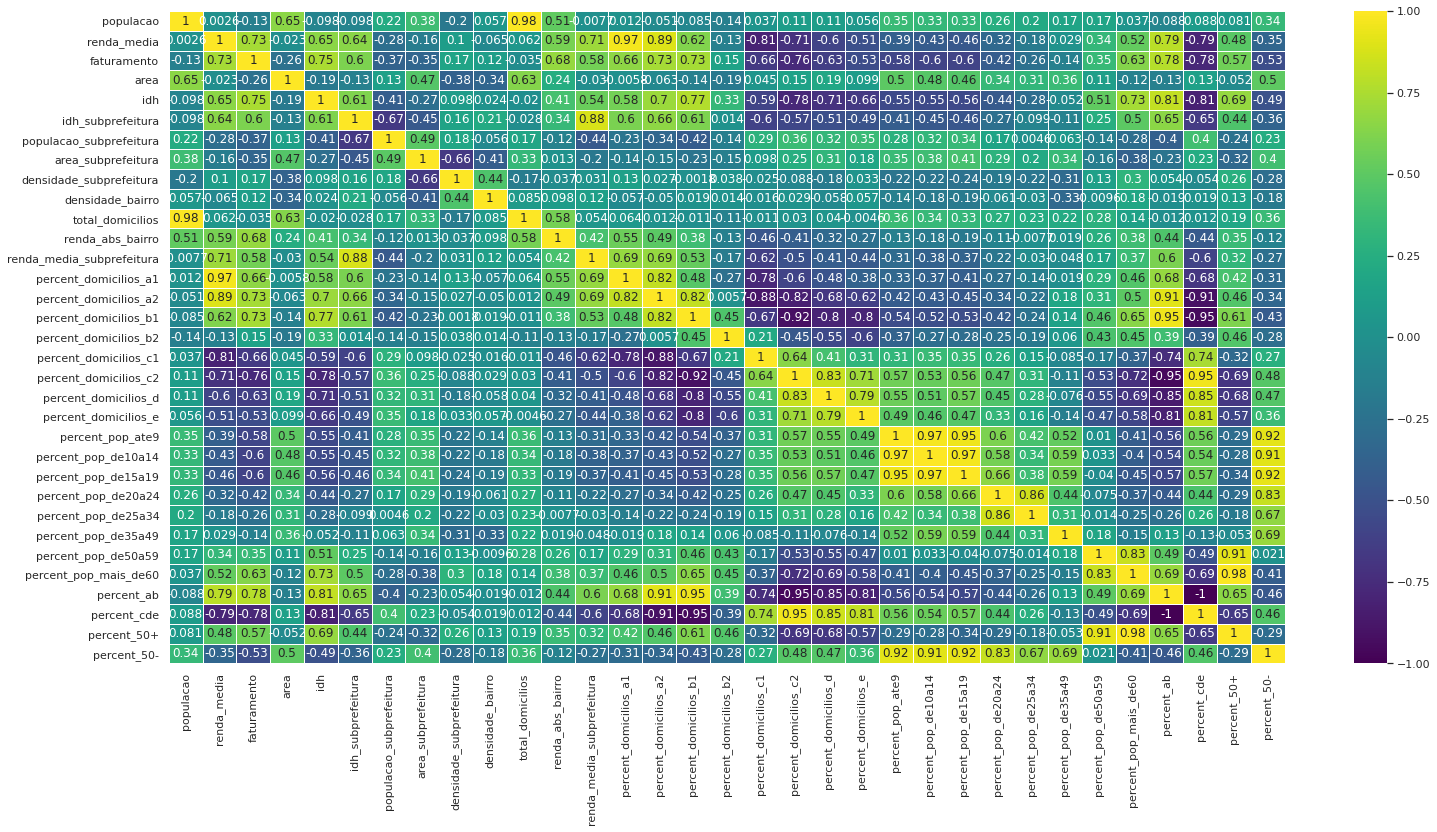

In [135]:
# Plot correlacao de todas as variaveis numericas
correlation = num_attributes.corr(method='pearson')
sns.heatmap(correlation, cmap='viridis', linewidths=.5, annot=True)

##### Idade

<AxesSubplot:>

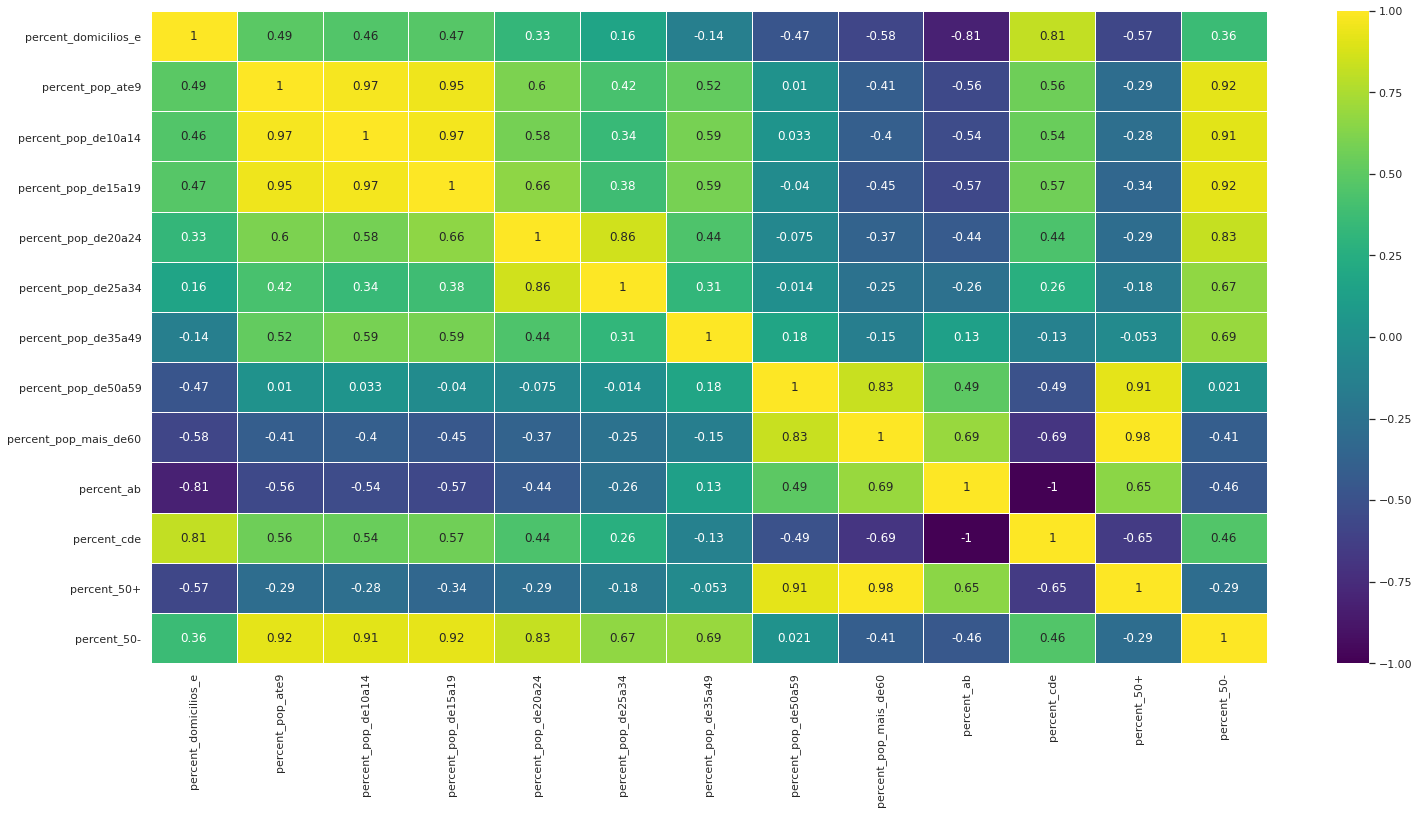

In [136]:
# Separando as variaveis de idade
age_att = num_attributes.iloc[:, 20:]

# Plot correlacao das variaveis de idade
correlation = age_att.corr(method='pearson')
sns.heatmap(correlation, cmap='viridis', linewidths=.5, annot=True)

#### Domicilio

<AxesSubplot:>

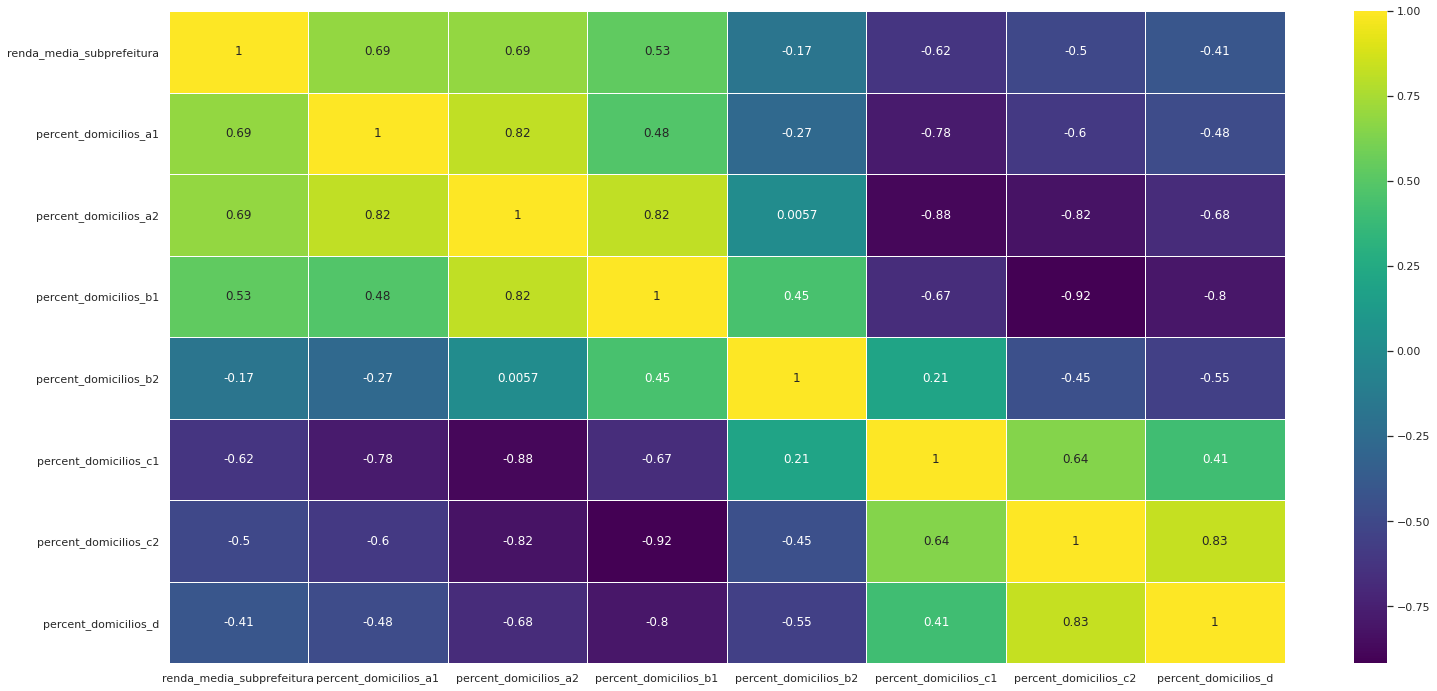

In [137]:
# Separando as variaveis de domicilio
domic_att = num_attributes.iloc[:, 12:20]

# Plot correlacao das variaveis de domicilio
correlation = domic_att.corr(method='pearson')
sns.heatmap(correlation, cmap='viridis', linewidths=.5, annot=True)

# 4.0. Filtragem

In [138]:
# copiando o dataframe para df4
df4 = df3.copy()

## 4.1. Filtragem de Colunas
Dropando colunas com pouca utilidade para o modelo

In [139]:
# drop das colunas
df4 = df4.drop(['codigo', 'nome', 'cidade', 'estado', 'regiao_adm'], axis=1)

## 4.2. Filtragem de Linhas - Analise de Outliers

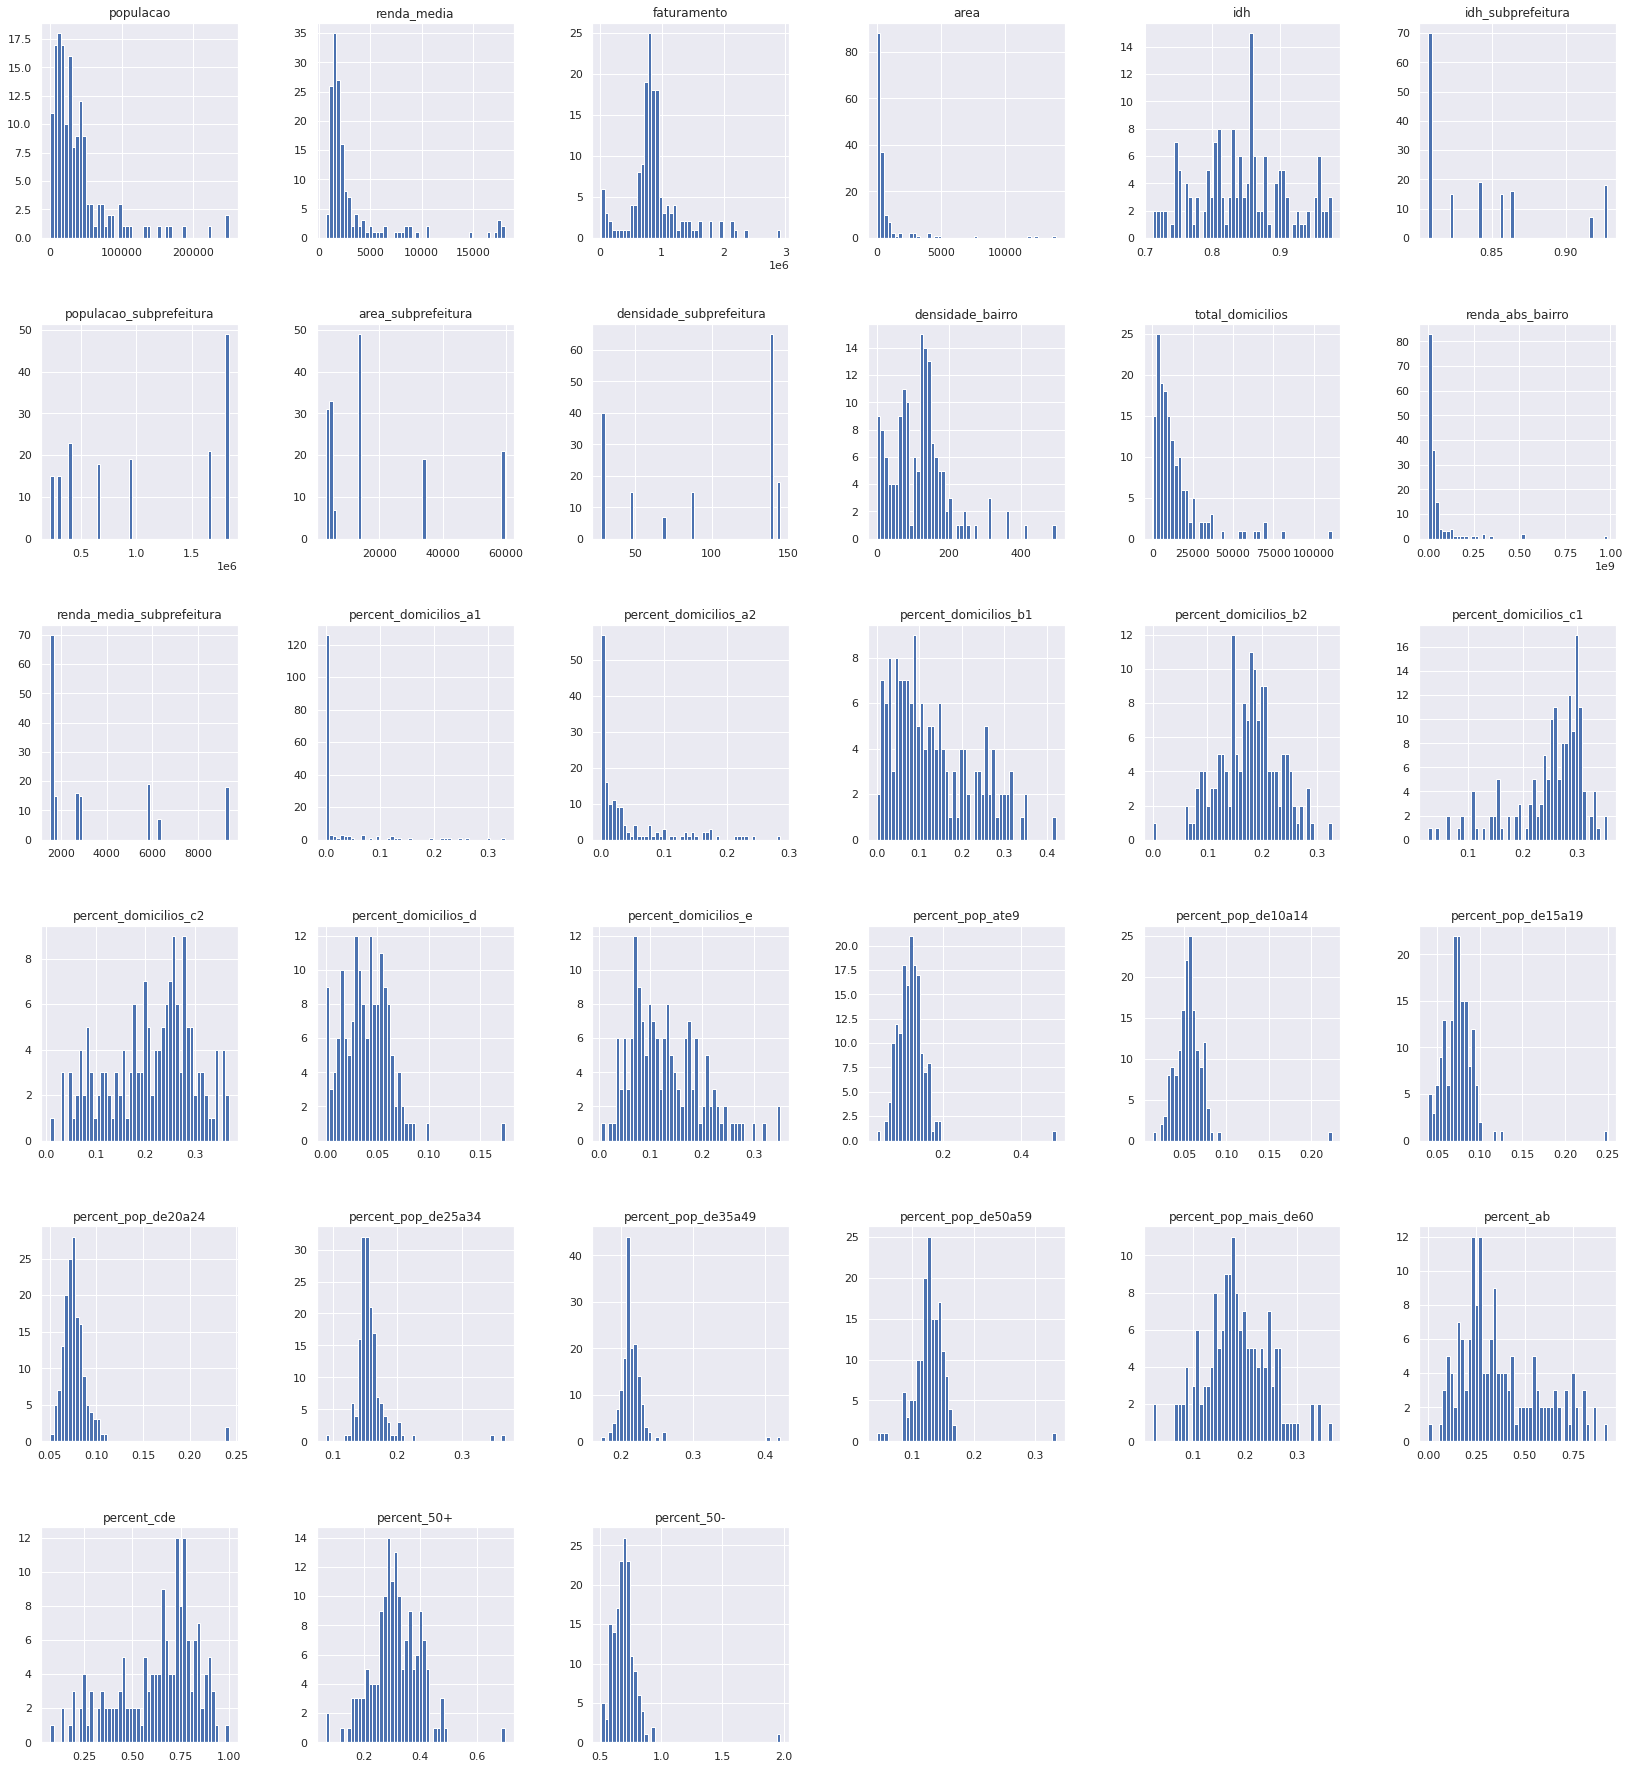

In [140]:
# print histogramas
df4.hist(bins=50);

# ajuste subplots
plt.subplots_adjust(left=0.125,
                    bottom=0.01, 
                    right=1, 
                    top=2, 
                    wspace=0.4, 
                    hspace=0.40)

Análise:
- populacao
- renda_media
- renda_abs_bairro
- total_domicilios
- percent 50-

<AxesSubplot:xlabel='percent_50-'>

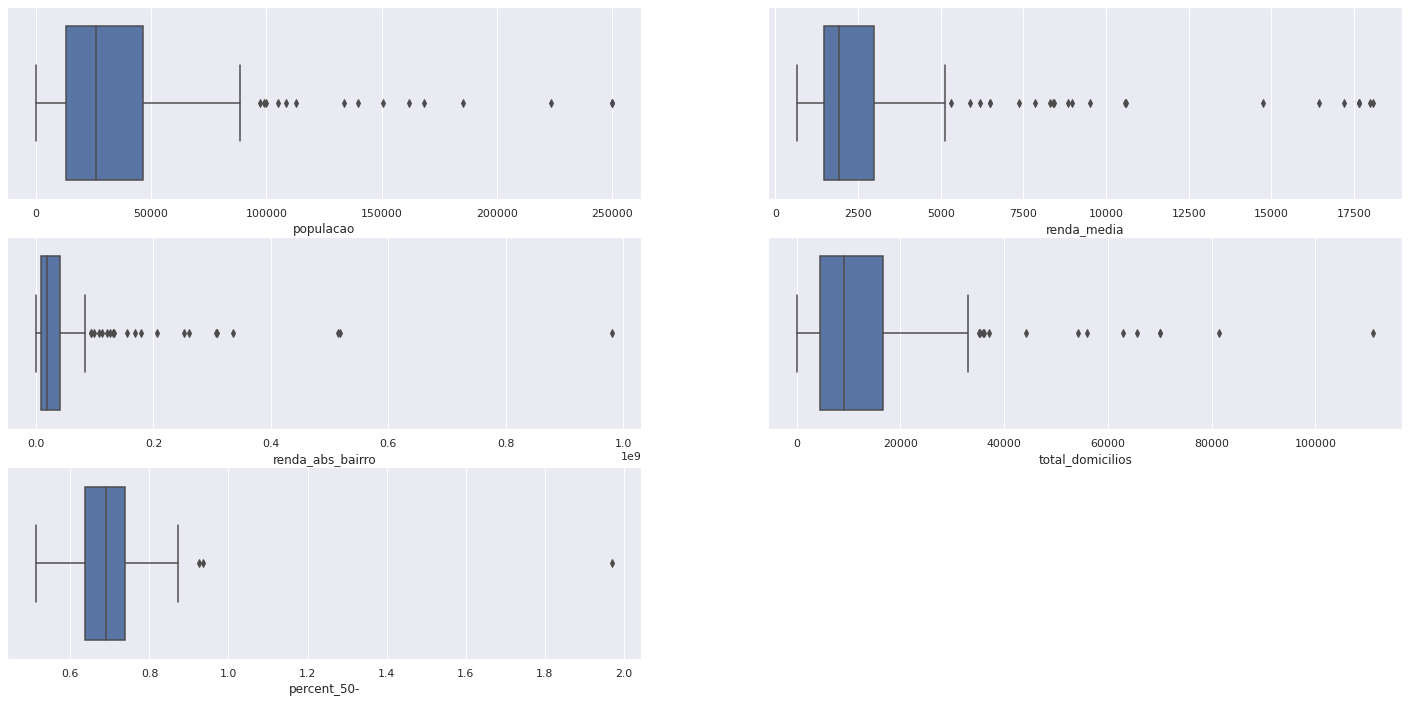

In [141]:
grid = plt.GridSpec(3, 2)

plt.subplot(grid[0, 0])
# plot boxplot populacao
sns.boxplot(x = df4['populacao'])

plt.subplot(grid[0, 1])
# plot boxplot renda_media
sns.boxplot(x = df4['renda_media'])

plt.subplot(grid[1, 0])
# plot boxplot renda_abs_bairro
sns.boxplot(x = df4['renda_abs_bairro'])

plt.subplot(grid[1, 1])
# plot boxplot total_domicilios
sns.boxplot(x = df4['total_domicilios'])

plt.subplot(grid[2, 0])
# plot boxplot total_domicilios
sns.boxplot(x = df4['percent_50-'])

In [142]:
# Determinando a partir de qual distancia os valores serao apagados - com IQR

# variavel populacao
outlier_pop = df4['populacao'].quantile([0.75]) + (df4['populacao'].quantile([0.75]).values - 
                                                   df4['populacao'].quantile([0.25]).values) * 3.5

# variavel renda_media
outlier_renda_media = df4['renda_media'].quantile([0.75]) + (df4['renda_media'].quantile([0.75]).values - 
                                                             df4['renda_media'].quantile([0.25]).values) * 3.5

# variavel renda_media
outlier_renda_abs = df4['renda_abs_bairro'].quantile([0.75]) + (df4['renda_abs_bairro'].quantile([0.75]).values - 
                                                             df4['renda_abs_bairro'].quantile([0.25]).values) * 2

# variavel total_domicilios
outlier_total_domicilios = df4['total_domicilios'].quantile([0.75]) + (df4['total_domicilios'].quantile([0.75]).values - 
                                                                       df4['total_domicilios'].quantile([0.25]).values) * 2

In [143]:
# DataFrame com os valores a serem excluidos
df_drops = pd.DataFrame([outlier_pop, outlier_renda_media, 
                         outlier_total_domicilios, outlier_renda_abs])

df_drops.loc['percent_50-'] = 1

# setando nome colunas
df_drops.columns = ['Drop_rows+']

# printando na tela o DF
df_drops

Drop_rows+
populacao                  162500.625
renda_media                  8252.500
total_domicilios            40621.750
renda_abs_bairro        106377451.000
percent_50-                     1.000

In [144]:
# Selecionando as linhas que deverao ser removidas
drop_rows = df4.loc[(df4['populacao'] > outlier_pop.values[0]) |
                    (df4['renda_media'] > outlier_renda_media.values[0]) |
                    (df4['total_domicilios'] > outlier_total_domicilios.values[0]) |
                    (df4['renda_abs_bairro'] > outlier_renda_abs.values[0]) |
                    (df4['percent_50-'] > 1), :]

In [145]:
# Verificando a procentagem do DataFrame que sera deletado
percent = round(drop_rows.shape[0] / df4.shape[0], 2) * 100

# Print porcentagem
print(f'{percent}% das linhas serão excluídas.')
print(f'Um total de {drop_rows.shape[0]} linhas')

17.0% das linhas serão excluídas.
Um total de 27 linhas


In [146]:
# Excluindo as colunas
df4 = df4.drop(drop_rows.index, axis=0)

<AxesSubplot:xlabel='percent_50-'>

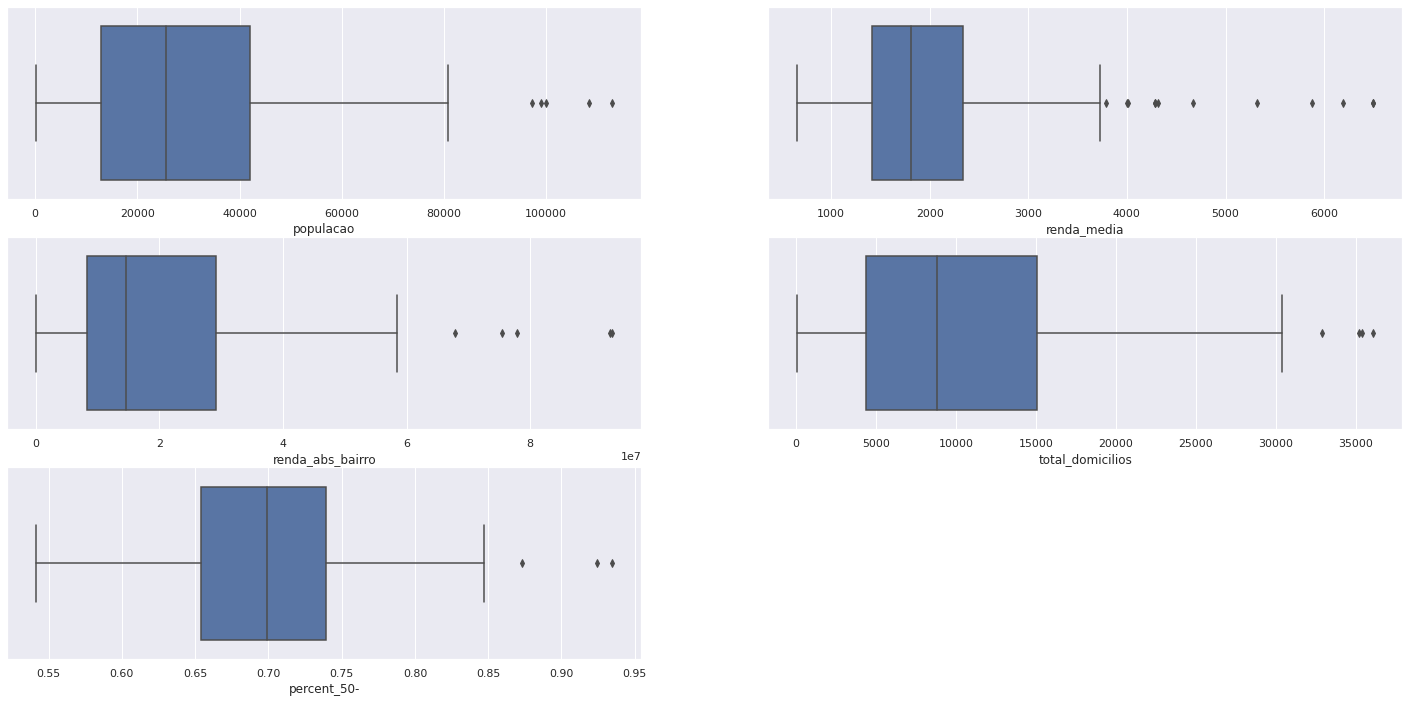

In [147]:
# Plotando novamente os bloxpots e visualizando as novas distribuicoes

grid = plt.GridSpec(3, 2)

plt.subplot(grid[0, 0])
# plot boxplot populacao
sns.boxplot(x = df4['populacao'])

plt.subplot(grid[0, 1])
# plot boxplot renda_media
sns.boxplot(x = df4['renda_media'])

plt.subplot(grid[1, 0])
# plot boxplot renda_abs_bairro
sns.boxplot(x = df4['renda_abs_bairro'])

plt.subplot(grid[1, 1])
# plot boxplot total_domicilios
sns.boxplot(x = df4['total_domicilios'])

plt.subplot(grid[2, 0])
# plot boxplot total_domicilios
sns.boxplot(x = df4['percent_50-'])

# 5.0. Tratamento

In [148]:
# copiando o dataframe para df5
df5 = df4.copy()

## 5.1. Separacao das Variaveis

In [149]:
# Separando as variaveis independentes
X = df5.drop('faturamento', axis=1)

# Separando a variável dependente
y = df5.loc[:, 'faturamento']

## 5.2. Encoding

In [150]:
# O Encoding nesse DataFrame sera simples.
# Sera utilizado o get_dummies. Ele transformara cada entrada possivel de uma coluna em uma nova feature 0 ou 1.

# gerando os dummies
dummies = pd.get_dummies(X['subprefeitura'])

# Colocando os dummies no DataFrame original
X = pd.merge(X, dummies, how='inner', left_index=True, right_index=True)

# Dropando a coluna antiga
X = X.drop('subprefeitura', axis=1)

## 5.3. Separacao Treino e Teste

In [151]:
# Separando o Dataset em Treino e Teste na proporcao 70/30
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=35)

## 5.4. Normalizacao da Variavel Resposta

In [152]:
# Transformando a variavel target na funcao log.

# treino
y_train = np.log1p(y_train)

# teste
y_test = np.log1p(y_test)

# total
y = np.log1p(y)

# 6.0. Selecao de Features

In [153]:
# copiando o dataframe para X_feat
X_feat = X_train.copy()

In [154]:
# Selecionando todas as variaveis em uma lista
list_columns = ['populacao', 'renda_media', 'area', 'idh', 'idh_subprefeitura',
                'populacao_subprefeitura', 'area_subprefeitura',
                'densidade_subprefeitura', 'densidade_bairro', 'total_domicilios',
                'renda_abs_bairro', 'renda_media_subprefeitura',
                'percent_domicilios_a1', 'percent_domicilios_a2',
                'percent_domicilios_b1', 'percent_domicilios_b2',
                'percent_domicilios_c1', 'percent_domicilios_c2',
                'percent_domicilios_d', 'percent_domicilios_e', 'percent_pop_ate9',
                'percent_pop_de10a14', 'percent_pop_de15a19', 'percent_pop_de20a24',
                'percent_pop_de25a34', 'percent_pop_de35a49', 'percent_pop_de50a59',
                'percent_pop_mais_de60', 'percent_ab', 'percent_cde', 'percent_50+',
                'percent_50-', 'Barra e Jacarepagua', 'Centro e Centro Historico',
                'Grande Meier', 'Grande Tijuca', 'Ilha do Governador', 'Zona Norte',
                'Zona Oeste', 'Zona Sul']

## 6.1. Selecao de Features - Boruta

In [155]:
# Features mais improtantes segundo o Boruta

# define RandomForestRegressor
rf = RandomForestRegressor(n_jobs=-1)

# define Boruta
boruta = BorutaPy(rf, n_estimators='auto', verbose=0, random_state=35).fit(X_feat.values, y_train.values)

In [156]:
# Colunas selecionadas pelo Boruta em lista
cols_selected = boruta.support_.tolist()

In [157]:
# Mostrando na tela as principais variaveis segundo o Boruta
cols_selected_boruta = X.iloc[:, cols_selected].columns.to_list()
cols_selected_boruta

['populacao',
 'idh',
 'total_domicilios',
 'percent_domicilios_c2',
 'percent_pop_ate9',
 'percent_ab',
 'percent_cde']

## 6.2. Selecao de Features - Manual

<AxesSubplot:>

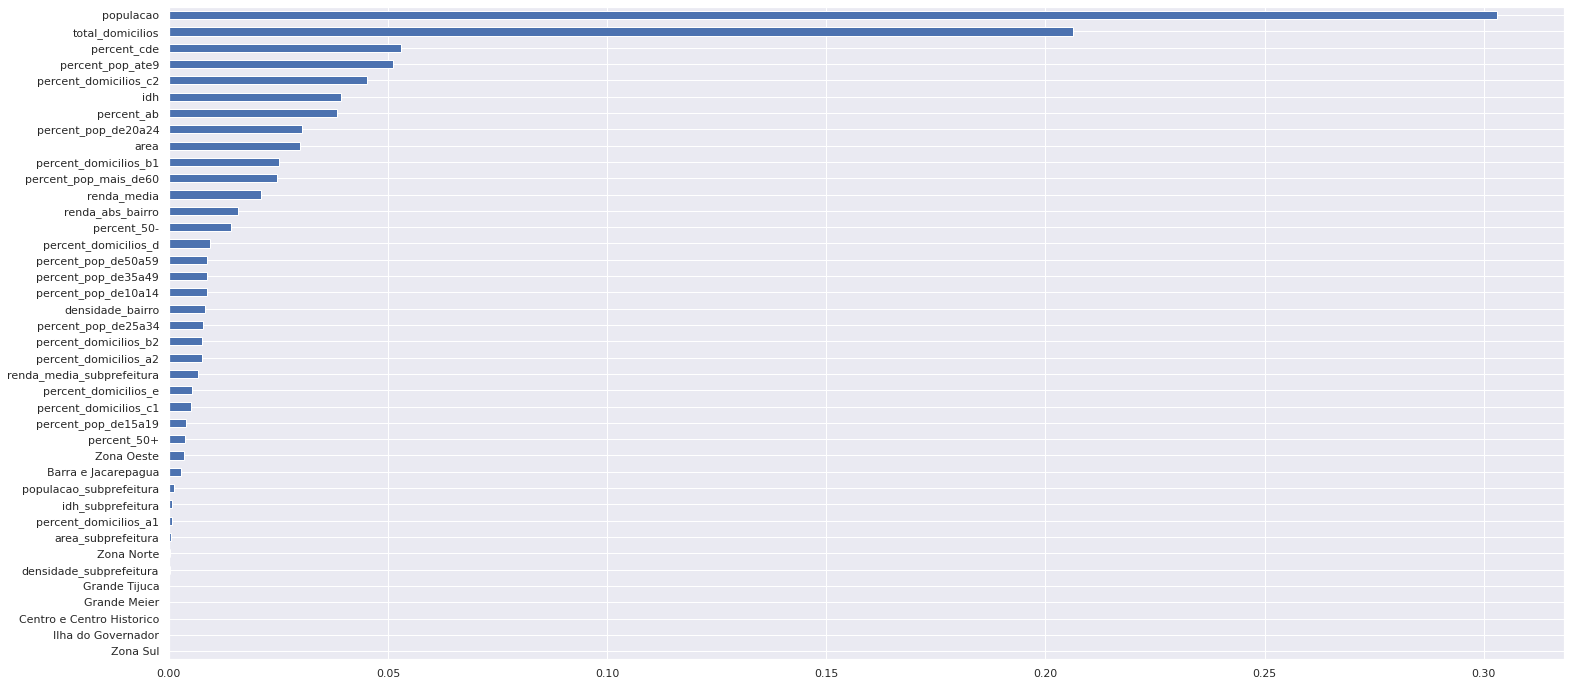

In [158]:
# Features mais improtantes segundo a selecao manual

# Determinando o modelo de RandomForestRegressor
rf_model = RandomForestRegressor()

# Treinando o modeelo
rf_model.fit(X_feat, y_train)

# Printando na tela
feat_importances = pd.Series(rf_model.feature_importances_, index=X.columns)
feat_importances.sort_values().plot(kind='barh')

In [159]:
feat_importances.sort_values(ascending=False).iloc[:10]

populacao                              0.303
total_domicilios                       0.206
percent_cde                            0.053
percent_pop_ate9                       0.051
percent_domicilios_c2                  0.045
idh                                    0.039
percent_ab                             0.038
percent_pop_de20a24                    0.030
area                                   0.030
percent_domicilios_b1                  0.025
dtype: float64

## 6.4. Selecao de Features - Recursive Feature Elimination (RFE)

In [160]:
# Features mais improtantes segundo a RFE

# determinando o RFE
rfe = RFE(estimator=rf_model, n_features_to_select=10)

# Treinando o RFE
fit = rfe.fit(X_feat, y_train)

In [161]:
# Criando um dicionario dos rankings e o populando
dict_ranking = {}
for value in range(X.shape[1]):
    dict_ranking[X.columns[value]] = rfe.ranking_[value]

In [162]:
# DF com as 10 principais features segundo o RFE
pd.DataFrame(dict_ranking, index=['Posicao']).T.sort_values(by='Posicao', ascending=True).head(15)

Posicao
populacao                    1
percent_ab                   1
percent_cde                  1
renda_abs_bairro             1
total_domicilios             1
percent_pop_de20a24          1
percent_pop_ate9             1
percent_pop_de25a34          1
idh                          1
percent_domicilios_c2        1
percent_domicilios_b1        2
percent_pop_de10a14          3
renda_media                  4
percent_pop_mais_de60        5
area                         6

## 6.5. Lista Final de Features

In [163]:
# colocando as features selecioandas em uma lista
features = ['idh', 'populacao','total_domicilios', 'percent_pop_ate9', 'percent_pop_de10a14',
            'percent_ab', 'densidade_bairro', 'percent_pop_mais_de60', 'renda_media']

# Selecionando apenas as features escolhidas em cada df

# treino
X_train = X_train[features]

# teste
X_test = X_test[features]

# total
X = X[features]

# 7.0. Modelagem de Machine Learning

## 7.1. Average Model - Baseline

In [164]:
# Baseline Avaliada em CrossValidation
model_bl = ml_performance(X_train, y_train, folds=10, baseline=True, tree=False)
model_bl

Model Name                  MAE                 MAPE                   R2
0  AverageModel           175562.783                0.486               -0.292


## 7.2. LinearRegression

In [165]:
# Treinando o modelo de Regressão Linear e avaliando em CrossValidation
model_lr = ml_performance(X_train, y_train, lm.LinearRegression(), folds=10, tree=False, scaler=MinMaxScaler())
model_lr

Model Name                        MAE             MAPE  \
0  LinearRegression  397460.828 +/- 179364.385  0.576 +/- 0.276   

                 R2  
0  -9.186 +/- 9.565

## 7.3. LinearRegression - Lasso

In [166]:
# Treinando o modelo Lasso e avaliando em CrossValidation
model_lasso = ml_performance(X_train, y_train, lm.Lasso(), folds=10, tree=False, scaler=MinMaxScaler())
model_lasso

Model Name                       MAE             MAPE                R2
0      Lasso  175562.783 +/- 53465.257  0.486 +/- 0.549  -0.292 +/- 0.284

## 7.4. LinearRegression - Ridge

In [167]:
# Treinando o modelo Ridge e avaliando em CrossValidation
model_ridge = ml_performance(X_train, y_train, lm.Ridge(), folds=10, tree=False, scaler=MinMaxScaler())
model_ridge

Model Name                       MAE             MAPE                R2
0      Ridge  260505.857 +/- 76243.379  0.435 +/- 0.201  -2.999 +/- 3.734

## 7.5. DecisionTreeRegressor

In [168]:
# Treinando o modelo de Arvore de Decisao e avaliando em CrossValidation
model_dt = ml_performance(X_train, y_train, DecisionTreeRegressor(random_state=35), folds=10, tree=True)
model_dt

Model Name                      MAE             MAPE  \
0  DecisionTreeRegressor  88037.093 +/- 39560.311  0.216 +/- 0.233   

                R2  
0  0.328 +/- 0.764

## 7.6. RandomForestRegressor

In [169]:
# Treinando o modelo de Random Forest e avaliando em CrossValidation
model_en = ml_performance(X_train, y_train, RandomForestRegressor(random_state=35), folds=10, tree=True)
model_en

Model Name                     MAE            MAPE  \
0  RandomForestRegressor  71734.998 +/- 31634.97  0.17 +/- 0.182   

                R2  
0  0.642 +/- 0.397

## 7.7. Comparacao

In [170]:
# Comparando todos os modelos em um unico DataFrame
comp = pd.concat([model_bl, model_lr, model_lasso, model_ridge, model_dt, model_en])
comp.index = comp['Model Name']
comp = comp.drop('Model Name', axis=1)

comp

MAE                 MAPE  \
Model Name                                                              
AverageModel                          175562.783                0.486   
LinearRegression       397460.828 +/- 179364.385      0.576 +/- 0.276   
Lasso                   175562.783 +/- 53465.257      0.486 +/- 0.549   
Ridge                   260505.857 +/- 76243.379      0.435 +/- 0.201   
DecisionTreeRegressor    88037.093 +/- 39560.311      0.216 +/- 0.233   
RandomForestRegressor     71734.998 +/- 31634.97       0.17 +/- 0.182   

                                        R2  
Model Name                                  
AverageModel                        -0.292  
LinearRegression          -9.186 +/- 9.565  
Lasso                     -0.292 +/- 0.284  
Ridge                     -2.999 +/- 3.734  
DecisionTreeRegressor      0.328 +/- 0.764  
RandomForestRegressor      0.642 +/- 0.397

Dentre todos os modelos analisados, o que melhor performou foi o RandomForestRegressor. Portanto, sera ele o usado.

# 8.0. Otimizacao de Hiperparametros

In [171]:
# Possiveis parametros
param = {'max_depth': [3, 5, 10, 15, 20, 30],
         'min_samples_leaf': [1, 2, 5, 10],
         'min_samples_split': [2, 5, 10, 15, 100],
         'n_estimators': [100, 300, 500, 700, 900, 1200]}

# Numero de iteracoes
MAX_EVAL = 100

In [172]:
## dicionario com todos os valores
#dict_iter = {}
#
## iteracoes
#for i in range(MAX_EVAL):
#    
#    # escolhendo os parametros de maneira aleatoria
#    hp = {k: random.sample( v, 1 )[0] for k, v in param.items()}
#    
#    # modelo
#    model_tr = en.RandomForestRegressor(max_depth = hp['max_depth'],
#                                        min_samples_leaf = hp['min_samples_leaf'],
#                                        min_samples_split = hp['min_samples_split'],
#                                        n_estimators = hp['n_estimators'],
#                                        random_state=35) 
#
#    
#    # treinando o modelo em CV
#    model_dt = ml_performance(X_train, y_train, model_tr, mape_eval=True, tree=True)
#    
#    # adicionando os valores e resultado no dicionario
#    dict_iter[model_dt] = hp

In [173]:
# Printando o melhor cenario
#df = pd.DataFrame(dict_iter).T.reset_index().sort_values(by='index')
#df.iloc[0, :]

# 9.0. Avaliacao

## 9.1. Test Data

In [174]:
model_final = RandomForestRegressor(max_depth = 30, min_samples_leaf = 1, 
                                       min_samples_split = 2, n_estimators=500,
                                       random_state=35)

In [175]:
# treinando o modelo
model_final.fit(X_train, y_train)

with open('/home/tcbm/projs/case_geofusion/model/model_faturamento.pkl', 'wb') as file:
    pickle.dump(model_final, file)

# fazendo as previsoes
yhat = model_final.predict(X_test)

# calculando o MAPE do modelo com os dados de teste
mean_absolute_percentage_error(np.expm1(y_test), np.expm1(yhat))

0.10510492375534435

## 9.2. CrossValidation em todos os dados

In [176]:
# Efetuando o CrossValidation do modelo com todos os dados
ml_performance(X, y, model_final, baseline=False, tree=True)

Model Name                      MAE             MAPE  \
0  RandomForestRegressor  55535.814 +/- 19556.411  0.109 +/- 0.086   

                R2  
0  0.717 +/- 0.453

# 10.0. Interpretação do Erro

In [177]:
# Juntando as variaveis de teste para interpretar os resultados
df10_to_merge = pd.merge(X_test, y_test, left_index=True, right_index=True)
nomes_index = df3.loc[df10_to_merge.index.values, 'nome']

# df10 como dataframe final para analise
df10 = pd.merge(nomes_index, df10_to_merge, left_index=True, right_index=True)

In [178]:
# Retomando os valores para a escala normal (aplicando a inversa do logaritmo - exponencial)
df10['faturamento'] = np.expm1(df10['faturamento'])
df10['previsao'] = np.expm1(yhat)

## 10.1. Business Performance

In [179]:
# Calculo do erro absoluto
df10['erro_absoluto'] = np.abs(df10['faturamento'] - df10['previsao'])

# Calculo do erro absoluto percentual
df10['erro_absoluto_percentual'] = np.abs((df10['faturamento'] - df10['previsao']) / df10['faturamento'])

# Pior cenario (previsao - erro absoluto)
df10['pior_cenario'] = df10['previsao'] - df10['erro_absoluto']

# Melhor cenario (previsao + erro absoluto)
df10['melhor_cenario'] = df10['previsao'] + df10['erro_absoluto']

# DataFrame com as métricas para serem analisadas, por cada bairro
df10_metricas = df10[['nome', 'previsao', 'pior_cenario', 'melhor_cenario', 'erro_absoluto', 'erro_absoluto_percentual']]

In [180]:
# Ordenando pelos maiores erros percentuais
df10_metricas.sort_values('erro_absoluto_percentual', ascending=False).head()

nome             previsao         pior_cenario  \
27   Complexo Do Alemao           224073.990            88790.000   
51                Penha           398000.808           202810.616   
122          Santissimo           660764.494           536367.000   
110              Cosmos           257344.465           219983.000   
17             Anchieta           644587.084           553020.000   

          melhor_cenario        erro_absoluto  erro_absoluto_percentual  
27            359357.979           135283.990                     1.524  
51            593191.000           195190.192                     0.329  
122           785161.987           124397.494                     0.232  
110           294705.930            37361.465                     0.170  
17            736154.168            91567.084                     0.166

<AxesSubplot:ylabel='erro_absoluto_percentual'>

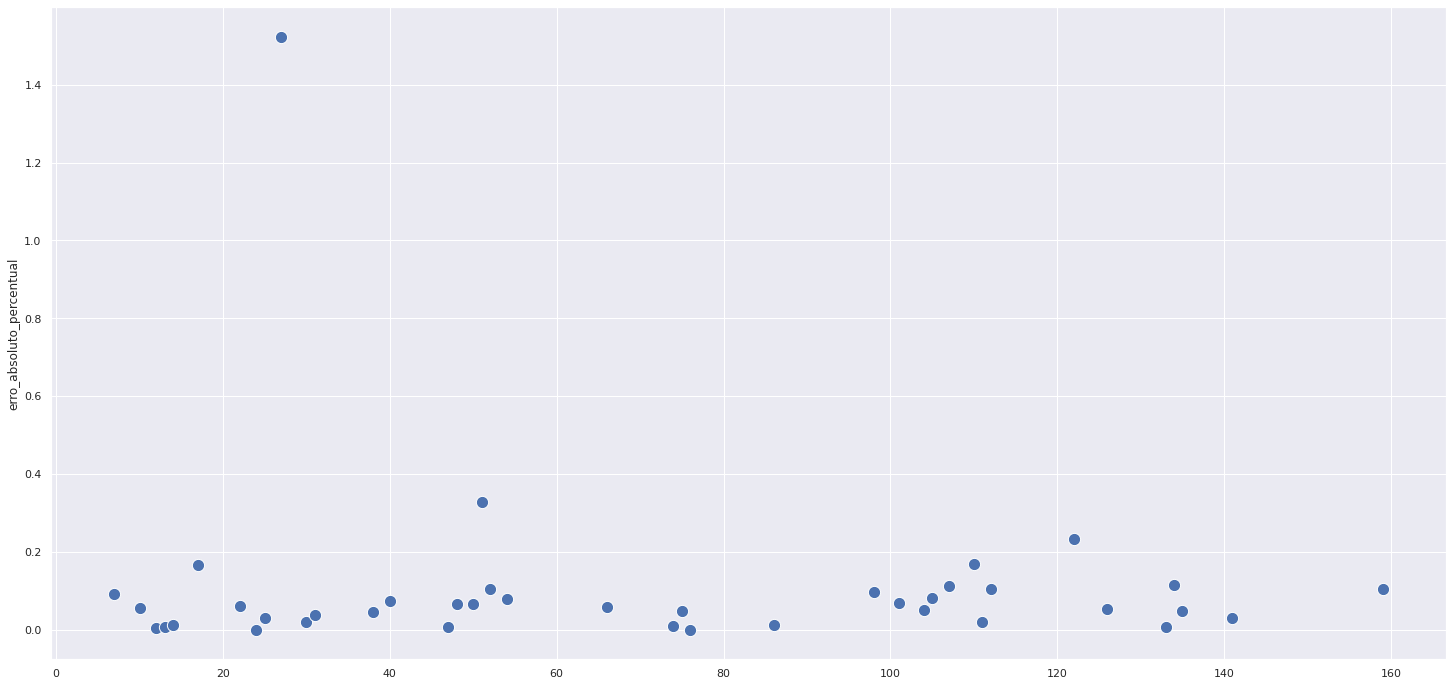

In [181]:
# plot scatterplot do erro absoluto percentual para os valores de teste
sns.scatterplot(x=df10.index.values, y=df10['erro_absoluto_percentual'], s=150)

## 10.2. Performance Total

In [182]:
# Juntando todos os valores para saber o cenario agregado do conjunto de teste
df10_2 = df10[['previsao', 'pior_cenario', 'melhor_cenario']].apply(lambda x: np.sum(x), axis=0).reset_index()
df10_2.columns = ['Cenário', 'Valores']

# Convertendo os valores em reais
df10_2['Valores'] = df10_2['Valores'].apply('R${:,.2f}'.format)

# Mostrando na tela
df10_2

Cenário          Valores
0        previsao  R$30,024,940.74
1    pior_cenario  R$27,964,412.84
2  melhor_cenario  R$32,085,468.64

## 10.3. Machine Learning Performance

In [183]:
# Calculo do erro (Ocorrido - Previsto)
df10['erro'] = df10['faturamento'] - df10['previsao']

# Error rate (Previsto / ocorrido)
df10['rate_erro'] = df10['previsao'] / df10['faturamento']

<AxesSubplot:xlabel='previsao', ylabel='erro'>

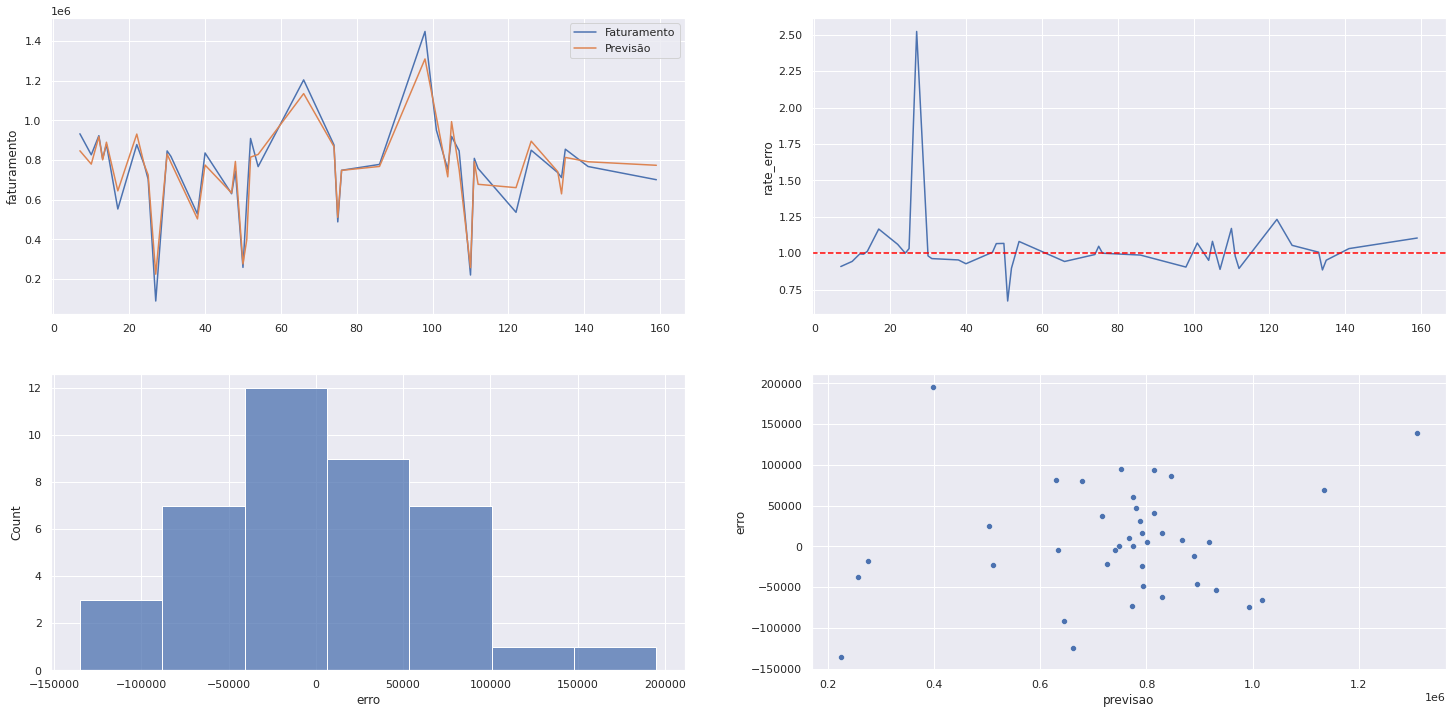

In [184]:
plt.subplot(2, 2, 1)
# Plot das diferencas entre valores
sns.lineplot(x=df10.index, y='faturamento', data=df10, label='Faturamento')
sns.lineplot(x=df10.index, y='previsao', data=df10, label='Previsão')

plt.subplot(2, 2, 2)
# Plot do erro percentual em comparacao com a media
sns.lineplot(x=df10.index, y='rate_erro', data=df10)
plt.axhline(1, linestyle='--', color='red')

plt.subplot(2, 2, 3)
# Plot da distribuicao do erro
sns.histplot(df10['erro'])

plt.subplot(2, 2, 4)
# Plot do espacamento dos erros
sns.scatterplot(x = df10['previsao'], y = df10['erro'])

In [185]:
# Salvando os DataFrames
#df10.to_csv('/home/tcbm/projs/case_geofusion/data/df_performance_1.csv', encoding='utf-8', index=False)
#df10_2.to_csv('/home/tcbm/projs/case_geofusion/data/df_performance_2.csv', encoding='utf-8', index=False)